# **Layout of Code**

### Step 1 - Conceptual Framework building for Iron Condor Analysis 
1. Instead of loading Data directly, we will build **Option Chain FrameWork** using the contract names present in the Month-wise nested Option Data Folder for FY2023. 

By Option Chain Framework, we mean list of all Contracts of type CE /PE for all the Strikes. There are a total of 12 monthly option series for stock option and 52 weekly option series for index options.

2. We assume that the data is stored in nested folder named after the month of their generation. For Example
    - 2023
        - Jan 2023
            - xxxx.csv
            - xxxx1.csv
            - ......csv
            - ......csv
            - xxxx2.csv  
        - Feb 2023
            - .....csv
        - March 2023
        - ..... 2023
        - ..... 2023
        - Dec 2023

Option Chain Frame Work is build using the ticker for each expiry. 

### Step 2 - Building Classes for Iron Condor

1. Using the Code above, We will build the Function for Iron Condor and Evaluate by extracting different performance parameters.

2. We will build Options Class , Iron Condor Class and Compare_Condor Class 
- Option Class - It will store Data and method to extarct the data
- Iron Condor Class - It will generate Iron Condor Based on Strikes, Lot Size and Symmetry about ATM Strike.
- Compare_Condor Class - It will compare the IRon Condor Class based on several Perfromance Parameters.  

### Step 3 - Comparion and Evaluation of Iron Condors

1. For each expiry series we deploy same Iron Condor Strategy for symmetric and asymmtric cases and compare the results. 

    - Strategy involves
        - A. Finding the ATM strike price for each expiry series at the begining of the expiry month 
        - B. Selecting short PE/CE 3 strikes away from the ATM strike and selecting long PE/CE 6 strikes away from the ATM strike
        - C. Evaluation performance for symmetric and asymetric cases

# STEP 1 : Conceptual Framework building for Iron Condor Analysis 

In this step, 
- We will build a python program to extarct data form the nested Option Data Folder, and arrange the Data in suitable format. 
- This compiled Data will be used for selecting suitable strikes as per the strategy. 
- Building function to extract the historical data of selected legs of Iron Condor.
- Using the historical Data and the selected Option Contracts, Build the Dataframe - 'Premium Data'  which will hold historical data of selected Contracts.
- Build the historical Performance of Iron Condor 

### Requirements 
1. Folder Structure should be in required format descibed below
2. All Files needs to be unzipped

In [124]:
# Importing Libraries required in the analysis
import os   
from datetime import datetime
import tqdm
import pandas as pd
import numpy as np 
import yfinance as yf
     

**In Code below**
- We build a list of all the contracts availble with us in the nested folders w or w/o extracting RaR files.
- Using pandas we build dataframe using infromation present in the contracts ticker name
- Columns are generated with 
    - Contract Names
    - Ticker
    - Expiry
    - Date
    - Type
    - Asset Type
    - Strike
    
- We avoid loading the data directly to save memory. We will build option Chain for each ticker + each exipry series combination. From the Option Chain , we select the ATM stike at the start of month and wait till end of month.- We will see the development of PnL Curve along with the following
    - Drawdown
    - Risk Adjusted Return

**Without Unzipping the Folders**

In the code Below , we extrct the contracts name from nested folders without unziping them to save memory. 

In [125]:
# This code build Option Chain Framework without Extracting the RaR files saving the Memory

## Issue Coming as Error 13 - Permission denied. To Be Checked Later

# import os
# import rarfile 
# import pandas as pd
# import numpy as np
# folder_path = 'C:/Users/paras/Downloads/2023'
# # Get all the rar archive in the folder
# archives = os.listdir(folder_path)
# option_contracts_list=[]
# for archive in archives:
#     print(archive)
#     month=str(archive).strip('Options').strip('2023.rar')
#     path="C:/Users/paras/Downloads/2023/"+str(archive)
#     archive=rarfile.RarFile(path,'r')
#     option_contracts_list.extend([x.strip('Options ').strip(month).strip('2023/').strip('.csv') for x in archive.namelist()])
# contracts_dataframe=pd.DataFrame(option_contracts_list,columns=['Contract Names'])


In the code below, 
- We will extract the file names of contracts present in the nested folder organisations
- Folders and Contract Tickers are named and placed according to Expiry, Strike, Option Type so  We will extract this information to build a Option chain Framework.

    - Step 1. Transverse Nested Folders and collect all file Paths + remove the extension .csv
    - Step 2. Store all file names in a DataFrame -> 'contracts_dataframe'

In [126]:
# This code build Option Chain Framework after Extracting the RaR files

root_folder = 'C:/Users/paras/Downloads/2023'           # Specify the root folder path where all the unzipped option monthly data is present.

# Function to traverse nested folders and collect file paths
def contracts_list(folder_path):
    file_paths = []
    for _, _, files in os.walk(folder_path):
        for file in files:
            file_paths.append(file[:-4])                # Collect file paths in the nested folder structure

    contracts_dataframe=pd.DataFrame(file_paths,columns=['Contract Names'])
    return contracts_dataframe

contracts_dataframe = contracts_list(root_folder)       # Here Function Returns the contract names as a dataframe object
contracts_dataframe

,Contract Names
0,AARTIIND230427440PE
1,AARTIIND230427450PE
2,AARTIIND230427460PE
3,AARTIIND230427470PE
4,AARTIIND230427480CE
...,...
307992,ZYDUSLIFE231130560PE
307993,ZYDUSLIFE231130590PE
307994,ZYDUSLIFE231130600PE
307995,ZYDUSLIFE231130650CE


In the above step , we have extracted all the file names. We will use these file names to build Option Chain Framework for all Ticker Symbols.

Using ***contracts_dataframe***, we will perform following steps on the contract names,

- Extract the Ticker symbol
- Extract the Expiry Date and convert it in correct format
- Extract the Strike 
- Extract the Type - PE/CE
- Assign the Asset Type 
- Build a new Dataframe with only Stock/Index Options 


In [127]:
from datetime import datetime     #For Datetime Processing and Transformations

def build_option_chain_framework(contracts_dataframe):

    #Extract the Ticker
    contracts_dataframe['Ticker']=contracts_dataframe['Contract Names'].apply(lambda x : (x[:x.find('2')]))
    #Extract the Expiry Date 
    contracts_dataframe['Expiry Date']=contracts_dataframe['Contract Names'].apply(lambda x : (x[x.find('2'):x.find('2')+6]))
    #Extract the Strike
    contracts_dataframe['Strike']=contracts_dataframe['Contract Names'].apply(lambda x : (x[x.find('2')+6:-2]))
    #Extract the Type - PE/CE
    contracts_dataframe['Type']=contracts_dataframe['Contract Names'].apply(lambda x: x[-2:])
    #Transformation of Expiry Date in correct format - %yy%mm%dd. This is followed throughout this project
    contracts_dataframe['Expiry Date']=contracts_dataframe['Expiry Date'].apply(lambda x : '20'+x)
    #Assign the Asset Type
    contracts_dataframe['Asset Type'] = np.where(contracts_dataframe['Expiry Date'].str.len() < 6, 'Commodity', 'Stocks/Index')
    #Selection of Only Stock.Index Options by Filtering Original Datframe and Saving it as new variable 'option_contracts_dataframe'
    option_contracts_dataframe=contracts_dataframe[contracts_dataframe['Asset Type']=='Stocks/Index'].copy()
    #Converting the Expiry Date Column into datetime format
    option_contracts_dataframe['Expiry Date']=option_contracts_dataframe['Expiry Date'].apply(lambda x : datetime.strptime(x,'%Y%m%d'))

    return option_contracts_dataframe


option_contracts_framework_2023=build_option_chain_framework(contracts_dataframe=contracts_dataframe) 

In [128]:
# This OCF forms the foundation block of analysis as all the strategy is building using this framework, and during impelementation of strategy , data is collected and processed using seperate function.
option_contracts_framework_2023  # Option Contract Data is stored in this variable

,Contract Names,Ticker,Expiry Date,Strike,Type,Asset Type
0,AARTIIND230427440PE,AARTIIND,2023-04-27,440,PE,Stocks/Index
1,AARTIIND230427450PE,AARTIIND,2023-04-27,450,PE,Stocks/Index
2,AARTIIND230427460PE,AARTIIND,2023-04-27,460,PE,Stocks/Index
3,AARTIIND230427470PE,AARTIIND,2023-04-27,470,PE,Stocks/Index
4,AARTIIND230427480CE,AARTIIND,2023-04-27,480,CE,Stocks/Index
...,...,...,...,...,...,...
307992,ZYDUSLIFE231130560PE,ZYDUSLIFE,2023-11-30,560,PE,Stocks/Index
307993,ZYDUSLIFE231130590PE,ZYDUSLIFE,2023-11-30,590,PE,Stocks/Index
307994,ZYDUSLIFE231130600PE,ZYDUSLIFE,2023-11-30,600,PE,Stocks/Index
307995,ZYDUSLIFE231130650CE,ZYDUSLIFE,2023-11-30,650,CE,Stocks/Index


In following code , we will extract list of all stock Index tickers from ***option_contracts_dataframe***

In [129]:
def get_tickers(framework):
    """
    framework : Pandas Dataframe of all contracts categorised based on Ticker , Expiry Date, Strike, Type of Option and Asset Type 
    """
    ticker_list=np.sort(list(set(framework['Ticker'])))    #Arranging Elements Alphabhetically 
    return list(ticker_list)

ticker_list=get_tickers(framework=option_contracts_framework_2023)
print("Option Contracts Framework 2023 has a total of ", len(ticker_list)," Tickers")
print("\nExample of Ticker List : -")
ticker_list[0:10]

Option Contracts Framework 2023 has a total of  207  Tickers

Example of Ticker List : -


['AARTIIND',
 'ABB',
 'ABBOTINDIA',
 'ABCAPITAL',
 'ABFRL',
 'ACC',
 'ADANIENT',
 'ADANIPORTS',
 'ALKEM',
 'AMBUJACEM']

We can extract the Option Chain Frame work for a particular stock.Index by filtering the option_contract_dataframe and sort them in ascending order by Expiry Dates


In [130]:
#For Example 
ticker='AMBUJACEM' #Any ticker from the ticker list can be choosen
option_contracts_framework_2023[option_contracts_framework_2023['Ticker']==ticker].sort_values(by='Expiry Date')

,Contract Names,Ticker,Expiry Date,Strike,Type,Asset Type
103129,AMBUJACEM230125590CE,AMBUJACEM,2023-01-25,590,CE,Stocks/Index
103115,AMBUJACEM230125550PE,AMBUJACEM,2023-01-25,550,PE,Stocks/Index
103113,AMBUJACEM230125545PE,AMBUJACEM,2023-01-25,545,PE,Stocks/Index
103112,AMBUJACEM230125545CE,AMBUJACEM,2023-01-25,545,CE,Stocks/Index
103111,AMBUJACEM230125540PE,AMBUJACEM,2023-01-25,540,PE,Stocks/Index
...,...,...,...,...,...,...
49854,AMBUJACEM240125465PE,AMBUJACEM,2024-01-25,465,PE,Stocks/Index
49861,AMBUJACEM240125485PE,AMBUJACEM,2024-01-25,485,PE,Stocks/Index
49903,AMBUJACEM240229590CE,AMBUJACEM,2024-02-29,590,CE,Stocks/Index
49901,AMBUJACEM240229450PE,AMBUJACEM,2024-02-29,450,PE,Stocks/Index


We can see form above example that the Expiry Dates of Feb 2024 are also included. We can Filter  results to 2023 only. 
In code below, we will Extract list of all Expiry Dates for a particular ticker and Filtering Expiry Dates for Year 2023



In [131]:
def get_expiry(ticker,framework,Year=[2023],filter_by_year=True):
    # Extract list of all Expiry Dates for a particular ticker
    expiry_dates_list=list(set(framework[framework['Ticker']==ticker]['Expiry Date']))
    if filter_by_year:
        # Filtering Expiry Dates for Year 2023
        expiry_dates_list = [date for date in expiry_dates_list if date.year == Year[0]]
        return np.sort(expiry_dates_list).tolist()
get_expiry(ticker=ticker_list[0],framework=option_contracts_framework_2023)

#These are the list of expiries for given ticker for the Year 2023

[Timestamp('2023-01-25 00:00:00'),
 Timestamp('2023-02-23 00:00:00'),
 Timestamp('2023-03-29 00:00:00'),
 Timestamp('2023-04-27 00:00:00'),
 Timestamp('2023-05-25 00:00:00'),
 Timestamp('2023-06-29 00:00:00'),
 Timestamp('2023-07-27 00:00:00'),
 Timestamp('2023-08-31 00:00:00'),
 Timestamp('2023-09-28 00:00:00'),
 Timestamp('2023-10-26 00:00:00'),
 Timestamp('2023-11-30 00:00:00'),
 Timestamp('2023-12-28 00:00:00')]

Till now we have Extracted all the information related to option/tickers/expiry dates.

In code below , we will build Option Chain for all strikes for a given Expiry Series without the premium values. 
This will not be used in final code, but it helps visually to undertand the process

In [132]:
def option_chain(ticker,expiry,framework):
    # Filter dataframe with ticker symbol and Expiry Date
    df=framework[(framework['Ticker'] == ticker) & (framework['Expiry Date'] == expiry)]
    # Extracting the PE Side and CE Side of the DataFrame to Merge them Horizontally on the Strike Price
    df_PE=df[df['Type']=='PE']
    df_CE=df[df['Type']=='CE']
    df=pd.merge(df_CE,df_PE,on='Strike')
    # Removing, Renaming and Re-Arranging the Columns to build Option Chain Structure

    #Removing unncessary columns 
    df.drop(['Ticker_x','Asset Type_x','Ticker_y','Expiry Date_y','Asset Type_y'],axis=1,inplace=True)
    #Renaming the columns
    df.rename(columns={"Contract Names_x":"Call Contracts",
                        "Expiry Date_x":"Expiry Dates",
                        "Type_x":"CE",
                        "Contract Names_y":"Put Contracts",
                        "Type_y":"PE"},inplace=True)
    #Rearranging the columns
    df=df[['Expiry Dates','CE','Call Contracts','Strike','Put Contracts','PE']]
    return df

# This function build option chains of a ticker for a given expiry and option chain framework
df= option_chain(ticker=ticker_list[0],
             expiry=get_expiry(ticker=ticker_list[0],framework=option_contracts_framework_2023)[0],
             framework=option_contracts_framework_2023)
df

,Expiry Dates,CE,Call Contracts,Strike,Put Contracts,PE
0,2023-01-25,CE,AARTIIND230125500CE,500,AARTIIND230125500PE,PE
1,2023-01-25,CE,AARTIIND230125540CE,540,AARTIIND230125540PE,PE
2,2023-01-25,CE,AARTIIND230125550CE,550,AARTIIND230125550PE,PE
3,2023-01-25,CE,AARTIIND230125560CE,560,AARTIIND230125560PE,PE
4,2023-01-25,CE,AARTIIND230125570CE,570,AARTIIND230125570PE,PE
5,2023-01-25,CE,AARTIIND230125580CE,580,AARTIIND230125580PE,PE
6,2023-01-25,CE,AARTIIND230125590CE,590,AARTIIND230125590PE,PE
7,2023-01-25,CE,AARTIIND230125600CE,600,AARTIIND230125600PE,PE
8,2023-01-25,CE,AARTIIND230125610CE,610,AARTIIND230125610PE,PE
9,2023-01-25,CE,AARTIIND230125620CE,620,AARTIIND230125620PE,PE


In above code, We have build Option chain for a given Ticker+Expiry combination.

As per the  Trading Strategy, We will use the 4 Option Contracts to build the Iron Condor

The Selection of 4 options are based on the ATM Strike Price of the Ticker at the Start of the New Expiry Series. We will short OTM PE/CE options 3 strike away from ATM Strike Price and Long DOTM PE/CE 6 strike away from the ATM Strike Price. 

After Selcting the Options Contracts based on above strategy, We will extract the option contract Data from the nested Folders - > This saves memory

Also the Folder Structures is such that , the option contract even if monthly extends beyond 1 month, since most buying happens at the inital stages to overcome the theta decay. To overcome this issue, we use following algorithm 

- Select the option contract.
- Look for the .csv file having option contract name in all folder ( Can be optimised by transerving in a limited range of folder)
- Concatenate Vertically all the .csv files present in different folders



**The historical data for different contracts have irregular timestamps as the data is of 1 minute and their order placements are independent of each other.**
**There are various method to solve this issue**

**1. Either we concatenate on similar time stamp, but this will remove important data at head and tail end**

**2. Or we resample the data to higher time stamp and then concatenate.**

**We will go with second option**
**We will focus only on the close price of the premiums and remove other rows**

In [133]:
def list_month_folders(root_folder):
    """
    This Fucntion will find the list of all the folders having monthly tick by tick data
    The struture of folders are assumed to be
    - 2023
        - Jan 2023
            - abc1.csv
            - abc2.csv
            - abc3.csv  
        - Feb 2023 
        ....
        ....
        - Dec 2023 
    """
    folders = []                                        # for storing folder paths 
    for item in os.listdir(root_folder):                
        # Folder structure has 2 level, root folder path and folder inside the root folder, so single iteration is enough
        item_path = os.path.join(root_folder, item)
        # if os.path.isdir(item_path):                  # Check 
        folders.append(item_path)
    return folders


def get_data(root_folder, filename):
    """
    This function trasverse all the nested folders and searches for the contract name and concat csv files with same nameon a single dataframe object. 
    
    """
    filename=filename+'.csv'
    month_folders=list_month_folders(root_folder)           # Saving Folder names
    # print(month_folders)                                  # This is used to see the output of months folders path 

    df=pd.DataFrame()
    for month_folder in month_folders:
        for foldername, _, filenames in os.walk(month_folder):
            if filename in filenames:
                file_path = os.path.join(foldername, filename)  # Build path for all .csv files having input contract name
                with open(file_path, 'r') as file:
                    data = pd.read_csv(file)
                    # Issue - > After merger only common datetime index remains. Can be inproved later stage.
                    df=pd.concat([df,data],axis=0)              # concat all csv files with input contract name 

    df.rename(columns={'<ticker>':'Ticker',                     # rename the columns of Datframe. 
                       '<date>':'Date',
                       '<time>':'Time',
                       '<open>':'Open',
                       '<high>':'High',
                       '<low>':'Low',
                       '<close>':'Close',
                       '<volume>':'Volume',
                       '<o/i>':'OI'}
                       ,inplace=True)
    df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'],format='mixed')   # Build Datetime column to be used as Index as data is of 1 minute TimeFrame - > Both Date and Time are important. 
    df.set_index(['Datetime'],inplace=True)
    df.sort_index(inplace=True)

    # Resampling the Data to 15 minute TimeFrame, which is used by Institutional Trading
    df=df.resample('15T').last()                                # Taking the Closing Price in 15 minute TimeFrame
    return df


In [134]:
# EXAMPLE OF USE OF get_data Function

root_folder = 'C:/Users/paras/Downloads/2023/'
filename = 'CHAMBLFERT230223315PE'

x=get_data(root_folder=root_folder,filename=filename)  # Hisotircal Data of contract = 'CHAMBLFERT230223315PE' 
x

,Ticker,Date,Time,Open,High,Low,Close,Volume,<o/i>
Datetime,,,,,,,,,
2023-02-01 09:15:00,CHAMBLFERT230223315PE,02/01/2023,09:29:00,12.10,12.10,12.00,12.00,9000.0,105000.0
2023-02-01 09:30:00,CHAMBLFERT230223315PE,02/01/2023,09:41:00,12.05,12.05,12.05,12.05,49500.0,174000.0
2023-02-01 09:45:00,CHAMBLFERT230223315PE,02/01/2023,09:58:00,13.20,13.20,13.20,13.20,9000.0,240000.0
2023-02-01 10:00:00,CHAMBLFERT230223315PE,02/01/2023,10:10:00,12.30,12.30,12.30,12.30,1500.0,261000.0
2023-02-01 10:15:00,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2023-02-23 13:30:00,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN
2023-02-23 13:45:00,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN
2023-02-23 14:00:00,CHAMBLFERT230223315PE,02/23/2023,14:00:00,37.95,37.95,37.95,37.95,1500.0,51000.0


We have method to build option chain and method to get the data, We will now build Iron Condor

In [135]:
df  # df stored in memory

,Expiry Dates,CE,Call Contracts,Strike,Put Contracts,PE
0,2023-01-25,CE,AARTIIND230125500CE,500,AARTIIND230125500PE,PE
1,2023-01-25,CE,AARTIIND230125540CE,540,AARTIIND230125540PE,PE
2,2023-01-25,CE,AARTIIND230125550CE,550,AARTIIND230125550PE,PE
3,2023-01-25,CE,AARTIIND230125560CE,560,AARTIIND230125560PE,PE
4,2023-01-25,CE,AARTIIND230125570CE,570,AARTIIND230125570PE,PE
5,2023-01-25,CE,AARTIIND230125580CE,580,AARTIIND230125580PE,PE
6,2023-01-25,CE,AARTIIND230125590CE,590,AARTIIND230125590PE,PE
7,2023-01-25,CE,AARTIIND230125600CE,600,AARTIIND230125600PE,PE
8,2023-01-25,CE,AARTIIND230125610CE,610,AARTIIND230125610PE,PE
9,2023-01-25,CE,AARTIIND230125620CE,620,AARTIIND230125620PE,PE


We will now build code to collect the market data from the yfinance with following objectives:
- Determine the Market Structure when Iron Condor is deployed - > whether market is trending (Bullish /Bearish) or Sideways
- Determine the ATM Strike price when Iron Condor is deployed 


In [136]:
import yfinance as yf
market_data=yf.download(ticker_list[0]+'.NS',start='2022-01-01',end='2024-02-01')
market_data['Returns']=market_data['Close'].pct_change()
market_data['Trends']='Sideways'
market_data.loc[market_data['Returns']>0.007,'Trends']='Bullish'
market_data.loc[market_data['Returns']<-0.007,'Trends']='Bearish'

expiries=get_expiry(ticker_list[0],framework=option_contracts_framework_2023)
print(market_data['Trends'].value_counts())

# Initialize a list to store trend classifications for each expiry region
expiry_trends = []

# Iterate through the list of expiry timestamps
flag=0
for i in range(0,len(expiries) - 1):
    # Define the start and end timestamps for the current expiry region
    if flag == 0:
        start_timestamp=datetime.strptime('2023-01-01', '%Y-%m-%d')
        end_timestamp = datetime.strptime('2023-01-25', '%Y-%m-%d')
        flag=flag+1
    else:
        start_timestamp = expiries[i-1]
        end_timestamp = expiries[i]
    

              
    start_date_of_expiry_series=start_timestamp
    try:
        specific_row = market_data.loc[start_date_of_expiry_series]
    except KeyError:
        # If the specific date is not found, find the next available date
        next_date = market_data.index[market_data.index > start_date_of_expiry_series][0]
        specific_row = market_data.loc[next_date]

    spot_price=int(specific_row['Close'])
    strike_list=option_chain(ticker=ticker_list[0],
                expiry=get_expiry(ticker=ticker_list[0],framework=option_contracts_framework_2023)[0],
                framework=option_contracts_framework_2023)['Strike']
    strike_list=[int(x) for x in strike_list]

    ATM_strike = min(strike_list, key=lambda x: abs(x - spot_price))
    

    # Extract the market data for the current expiry region
    region_data = market_data.loc[(market_data.index >= start_timestamp) & (market_data.index < end_timestamp)]
    
    # Count the occurrences of each trend type in the current expiry region
    trend_counts = region_data['Trends'].value_counts()
    
    # Assign the trend with the maximum count as the trend for the current expiry region
    dominant_trend = trend_counts.idxmax()
    
    # Append the dominant trend for the current expiry region to the list
    expiry_trends.append((start_timestamp, end_timestamp, dominant_trend , ATM_strike))

# Convert the list of expiry trends into a DataFrame for easier manipulation and analysis
expiry_trends_df = pd.DataFrame(expiry_trends, columns=['Start of Expiry Series', 'End of Expiry Series', 'Trend', 'ATM Strike'])




expiry_trends_df

[*********************100%%**********************]  1 of 1 completed


Trends
Sideways    181
Bearish     174
Bullish     159
Name: count, dtype: int64


,Start of Expiry Series,End of Expiry Series,Trend,ATM Strike
0,2023-01-01,2023-01-25,Sideways,610
1,2023-01-25,2023-02-23,Bearish,540
2,2023-02-23,2023-03-29,Bearish,500
3,2023-03-29,2023-04-27,Bullish,500
4,2023-04-27,2023-05-25,Sideways,550
5,2023-05-25,2023-06-29,Sideways,500
6,2023-06-29,2023-07-27,Bearish,500
7,2023-07-27,2023-08-31,Sideways,500
8,2023-08-31,2023-09-28,Sideways,500
9,2023-09-28,2023-10-26,Bearish,500


In Above dataframe, we have defined the ATM of Strike for different Expiries and Also the trend market is going through

In [137]:
df=option_chain(ticker=ticker_list[0],
                expiry=get_expiry(ticker=ticker_list[0],framework=option_contracts_framework_2023)[0],
                framework=option_contracts_framework_2023)

df

,Expiry Dates,CE,Call Contracts,Strike,Put Contracts,PE
0,2023-01-25,CE,AARTIIND230125500CE,500,AARTIIND230125500PE,PE
1,2023-01-25,CE,AARTIIND230125540CE,540,AARTIIND230125540PE,PE
2,2023-01-25,CE,AARTIIND230125550CE,550,AARTIIND230125550PE,PE
3,2023-01-25,CE,AARTIIND230125560CE,560,AARTIIND230125560PE,PE
4,2023-01-25,CE,AARTIIND230125570CE,570,AARTIIND230125570PE,PE
5,2023-01-25,CE,AARTIIND230125580CE,580,AARTIIND230125580PE,PE
6,2023-01-25,CE,AARTIIND230125590CE,590,AARTIIND230125590PE,PE
7,2023-01-25,CE,AARTIIND230125600CE,600,AARTIIND230125600PE,PE
8,2023-01-25,CE,AARTIIND230125610CE,610,AARTIIND230125610PE,PE
9,2023-01-25,CE,AARTIIND230125620CE,620,AARTIIND230125620PE,PE


Building Iron Condor for specific ticker for specific Expiry

In [138]:
# Selection the ATM Strike for first expiry

ATM_strike=expiry_trends_df['ATM Strike'][0]
market_trend=expiry_trends_df['Trend'][0]

df=option_chain(ticker=ticker_list[0],
                expiry=get_expiry(ticker=ticker_list[0],framework=option_contracts_framework_2023)[0],
                framework=option_contracts_framework_2023)
df['Strike']=df['Strike'].astype(int)
df.index[df['Strike']==ATM_strike]
# Selecting strike for legs of the Iron Condor
put_short_strike=df['Strike'].loc[df.index[df['Strike']==ATM_strike][0]-3]           # Short OTM Put 3 strike away from ATM Strike
call_short_strike=df['Strike'].loc[df.index[df['Strike']==ATM_strike][0]+3]          # Short OTM Call 3 strike away from ATM Strike
put_long_strike=df['Strike'].loc[df.index[df['Strike']==ATM_strike][0]-6]            # Short DOTM Put 6 strike away from ATM Strike
call_long_strike=df['Strike'].loc[df.index[df['Strike']==ATM_strike][0]+6]           # Short DOTM Call 6 strike away from ATM Strike

# call_short_strike
# Finding the name of contracts of Iron condor
put_short_contract_name=df['Put Contracts'].loc[df.index[df['Strike']==ATM_strike][0]-3] 
call_short_contract_name=df['Call Contracts'].loc[df.index[df['Strike']==ATM_strike][0]+3] 
put_long_contract_name=df['Put Contracts'].loc[df.index[df['Strike']==ATM_strike][0]-6]  
call_long_contract_name=df['Call Contracts'].loc[df.index[df['Strike']==ATM_strike][0]+6]  

# #Getting Historical Data of selected contracts
put_short_contract_data=get_data(root_folder=root_folder,filename=put_short_contract_name)['Close']
call_short_contract_data=get_data(root_folder=root_folder,filename=call_short_contract_name)['Close']
put_long_contract_data=get_data(root_folder=root_folder,filename=put_long_contract_name)['Close']
call_long_contract_data=get_data(root_folder=root_folder,filename=call_long_contract_name)['Close']

# combining all the premium data
premium_data=pd.concat([put_short_contract_data,call_short_contract_data,put_long_contract_data,call_long_contract_data]
                       ,keys=['Put Short','Call Short','Put Long','Call Long'],axis=1).dropna()
premium_data['Price of Iron Condor'] = np.round(premium_data['Put Short']+premium_data['Call Short'] - premium_data['Put Long']-premium_data['Call Long'],3)
premium_data['Profit']=np.round(premium_data['Price of Iron Condor'].apply(lambda x : -x+premium_data['Price of Iron Condor'][0]),3)
ticker_name=df['Call Contracts'][0][:df['Call Contracts'][0].find('23')]
Profit=premium_data['Profit'][-1:]
Backtested_samples=premium_data.shape[0]
Expiry=df['Expiry Dates'][0]
Maxmium_profit=premium_data['Profit'].max()
Maxmium_profit_index=premium_data['Profit'].idxmax()
distance=premium_data.index.get_loc(premium_data['Profit'].idxmax())+1
print(distance/len(premium_data)*100)

print(f'Iron Condor Profit at the end of Expiry Series {Profit}')
print(f'Maximum profit during the Strategy { Maxmium_profit}') # Percentage from start to be included later
premium_data




18.181818181818183
Iron Condor Profit at the end of Expiry Series Datetime
2023-01-25 13:00:00   -21.55
Name: Profit, dtype: float64
Maximum profit during the Strategy 1.95


,Put Short,Call Short,Put Long,Call Long,Price of Iron Condor,Profit
Datetime,,,,,,
2023-01-03 14:45:00,4.50,9.50,1.45,3.75,8.80,0.00
2023-01-05 14:45:00,5.20,5.05,1.45,1.95,6.85,1.95
2023-01-06 11:30:00,7.05,4.65,1.70,1.75,8.25,0.55
2023-01-06 12:15:00,8.00,4.00,2.05,1.45,8.50,0.30
2023-01-06 12:45:00,9.25,3.50,2.50,1.35,8.90,-0.10
2023-01-06 15:15:00,7.80,4.30,2.25,1.50,8.35,0.45
2023-01-13 15:15:00,9.75,1.05,1.90,0.60,8.30,0.50
2023-01-24 09:15:00,18.30,0.10,1.60,0.10,16.70,-7.90
2023-01-24 09:45:00,18.50,0.10,1.10,0.20,17.30,-8.50


In the above code we have build the Iron condor and historical Data of Contracts used as legs of Iron Condor.

Above Table shows the profit and Loss for Iron condor for a given expiry if all legs are held till expiry ( or till data is option data of all 4 legs are available)

We can plot the Iron Condor PnL with Time using code below

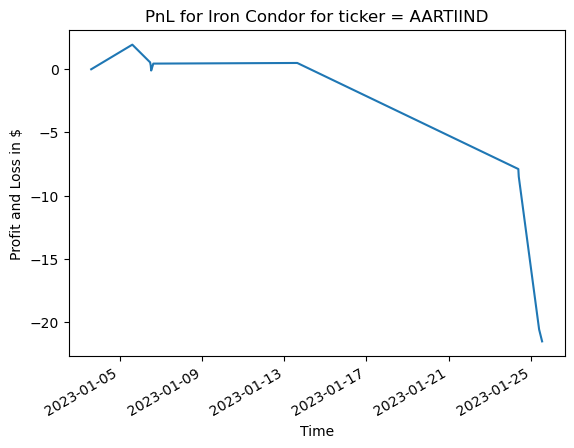

In [139]:
premium_data['Profit'].plot(
    title=f'PnL for Iron Condor for ticker = {ticker_name}',
    xlabel='Time',
    ylabel='Profit and Loss in $');

Building the whole code again for 1 ticker for all the expiries and compiling the performance data

In [140]:
from tqdm import tqdm
import yfinance as yf
performance=pd.DataFrame()
ticker=ticker_list[0]

set_print=False          # Change this to false if no priniting is required during execution. Else set it True


market_data=yf.download(ticker+'.NS',start='2022-01-01',end='2024-02-01')
market_data['Returns']=market_data['Close'].pct_change()
market_data['Trends']='Sideways'
market_data.loc[market_data['Returns']>0.007,'Trends']='Bullish'
market_data.loc[market_data['Returns']<-0.007,'Trends']='Bearish'

expiries=get_expiry(ticker_list[0],framework=option_contracts_framework_2023)
if set_print:
    print(market_data['Trends'].value_counts())

# Initialize a list to store trend classifications for each expiry region
expiry_trends = []

# Iterate through the list of expiry timestamps
flag=0
for i in range(0,len(expiries)):
    # Define the start and end timestamps for the current expiry region
    if flag == 0:
        start_timestamp=datetime.strptime('2023-01-01', '%Y-%m-%d')
        end_timestamp = datetime.strptime('2023-01-25', '%Y-%m-%d')
        flag=flag+1
    else:
        start_timestamp = expiries[i-1]
        end_timestamp = expiries[i]
    
           
    start_date_of_expiry_series=start_timestamp
    try:
        specific_row = market_data.loc[start_date_of_expiry_series]
    except KeyError:
        # If the specific date is not found, find the next available date
        next_date = market_data.index[market_data.index > start_date_of_expiry_series][0]
        specific_row = market_data.loc[next_date]

    spot_price=int(specific_row['Close'])
    strike_list=option_chain(ticker=ticker,
                expiry=get_expiry(ticker=ticker,framework=option_contracts_framework_2023)[0],
                framework=option_contracts_framework_2023)['Strike']
    strike_list=[int(x) for x in strike_list]

    ATM_strike = min(strike_list, key=lambda x: abs(x - spot_price))
    

    # Extract the market data for the current expiry region
    region_data = market_data.loc[(market_data.index >= start_timestamp) & (market_data.index < end_timestamp)]
    
    # Count the occurrences of each trend type in the current expiry region
    trend_counts = region_data['Trends'].value_counts()
    
    # Assign the trend with the maximum count as the trend for the current expiry region
    dominant_trend = trend_counts.idxmax()
    
    # Append the dominant trend for the current expiry region to the list
    expiry_trends.append((start_timestamp, end_timestamp, dominant_trend , ATM_strike))

# Convert the list of expiry trends into a DataFrame for easier manipulation and analysis
expiry_trends_df = pd.DataFrame(expiry_trends, columns=['Start of Expiry Series', 'End of Expiry Series', 'Trend', 'ATM Strike'])



for expiry_date in tqdm(get_expiry(ticker=ticker,framework=option_contracts_framework_2023), desc="Processing", unit="expiry",position=0):
    #For a particular Expiry, deploy an Iron Condor at the begining of Option Monthly Expiry Series. and it is held till end of monthly expiry.
    df=option_contracts_framework_2023[(option_contracts_framework_2023['Ticker'] == ticker_list[1]) & (option_contracts_framework_2023['Expiry Date'] == expiry_date)]
    df_PE=df[df['Type']=='PE']
    df_CE=df[df['Type']=='CE']
    df=pd.merge(df_CE,df_PE,on='Strike')
    df.drop(['Ticker_x','Asset Type_x','Ticker_y','Expiry Date_y','Asset Type_y'],axis=1,inplace=True)
    df.rename(columns={"Contract Names_x":"Call Contracts",
                        "Expiry Date_x":"Expiry Dates",
                        "Type_x":"CE",
                        "Contract Names_y":"Put Contracts",
                        "Type_y":"Type"},inplace=True)
    
    # Building Iron Condor

    # Selection the ITM Strike - middle value of list
    ATM_strike=expiry_trends_df[expiry_trends_df['End of Expiry Series']==expiry_date]['ATM Strike'].iloc[0]
    if set_print:
        print(ATM_strike)
                                                                                                    
    market_trend=expiry_trends_df[expiry_trends_df['End of Expiry Series']==expiry_date]['Trend'].iloc[0]
    if set_print:
        print(market_trend)

    df=option_chain(ticker=ticker_list[0],
                    expiry=expiry_date,
                    framework=option_contracts_framework_2023)
    df['Strike']=df['Strike'].astype(int)
    if set_print:
        print(df)
    df.index[df['Strike']==ATM_strike]
    # Selecting strike for legs of the Iron Condor
    put_short_strike=df['Strike'].loc[df.index[df['Strike']==ATM_strike][0]-3]           # Short OTM Put 3 strike away from ATM Strike
    call_short_strike=df['Strike'].loc[df.index[df['Strike']==ATM_strike][0]+3]          # Short OTM Call 3 strike away from ATM Strike
    put_long_strike=df['Strike'].loc[df.index[df['Strike']==ATM_strike][0]-6]            # Short DOTM Put 6 strike away from ATM Strike
    call_long_strike=df['Strike'].loc[df.index[df['Strike']==ATM_strike][0]+6]           # Short DOTM Call 6 strike away from ATM Strike
    if set_print:
        print(put_short_strike,call_short_strike,put_long_strike,call_long_strike)

    # Finding the name of contracts of Iron condor
    put_short_contract_name=df['Put Contracts'].loc[df.index[df['Strike']==ATM_strike][0]-3] 
    call_short_contract_name=df['Call Contracts'].loc[df.index[df['Strike']==ATM_strike][0]+3] 
    put_long_contract_name=df['Put Contracts'].loc[df.index[df['Strike']==ATM_strike][0]-6]  
    call_long_contract_name=df['Call Contracts'].loc[df.index[df['Strike']==ATM_strike][0]+6]  

    if set_print:
        print(put_short_contract_name,call_short_contract_name,put_long_contract_name,call_long_contract_name)

    # Getting Historical Data of selected contracts
    put_short_contract_data=get_data(root_folder=root_folder,filename=put_short_contract_name)['Close']
    call_short_contract_data=get_data(root_folder=root_folder,filename=call_short_contract_name)['Close']
    put_long_contract_data=get_data(root_folder=root_folder,filename=put_long_contract_name)['Close']
    call_long_contract_data=get_data(root_folder=root_folder,filename=call_long_contract_name)['Close']

    # combining all the premium data
    premium_data=pd.concat([put_short_contract_data,call_short_contract_data,put_long_contract_data,call_long_contract_data]
                        ,keys=['Put Short','Call Short','Put Long','Call Long'],axis=1).dropna()
    premium_data['Price of Iron Condor'] = np.round(premium_data['Put Short']+premium_data['Call Short'] - premium_data['Put Long']-premium_data['Call Long'],3)
    premium_data['Profit']=np.round(premium_data['Price of Iron Condor'].apply(lambda x : -x+premium_data['Price of Iron Condor'][0]),3)
    if set_print:
        print(premium_data)
    ticker_name=df['Call Contracts'][0][:df['Call Contracts'][0].find('23')]
    Profit=premium_data['Profit'][-1]
    Backtested_samples=premium_data.shape[0]
    Maxmium_profit=premium_data['Profit'].max()
    Percentage_duration_at_max_profit=(premium_data.index.get_loc(premium_data['Profit'].idxmax())+1)/len(premium_data)*100
    Expiry=expiry_date
    performance_df = pd.DataFrame({'Backtested Samples': Backtested_samples,
                                   'Profit till Expiry': Profit,
                                   'Maximum Profit':Maxmium_profit,
                                   'Duration % at Max Profit':np.round(Percentage_duration_at_max_profit,3),
                                    'Market Trend' :market_trend},index=[expiry_date.date()]).rename_axis('Expiry Date')

    performance = pd.concat([performance, performance_df])

performance

[*********************100%%**********************]  1 of 1 completed
Processing: 100%|██████████| 12/12 [00:29<00:00,  2.44s/expiry]


,Backtested Samples,Profit till Expiry,Maximum Profit,Duration % at Max Profit,Market Trend
Expiry Date,,,,,
2023-01-25,11,-21.55,1.95,18.182,Sideways
2023-02-23,402,-0.40,4.75,99.005,Bearish
2023-03-29,23,2.30,3.90,91.304,Bearish
2023-04-27,46,-0.40,2.05,13.043,Bullish
2023-05-25,49,-3.00,1.10,77.551,Sideways
2023-06-29,121,0.15,6.25,7.438,Sideways
2023-07-27,99,-2.40,1.30,73.737,Bearish
2023-08-31,37,-0.40,3.30,94.595,Sideways
2023-09-28,369,1.30,4.75,32.249,Sideways


We will Calculate the statistical behaviour of performance data

In [141]:
statistical_performance = pd.DataFrame({'Mean Profit':performance['Profit till Expiry'].mean(),
                                        'Std Profit':performance['Profit till Expiry'].std(),
                                        'Risk Adjusted Profit' : performance['Profit till Expiry'].mean()/performance['Profit till Expiry'].std(),
                                        'Mean Max Profit':performance['Maximum Profit'].mean(),},index=['Ticker to be added in final code'])
statistical_performance


,Mean Profit,Std Profit,Risk Adjusted Profit,Mean Max Profit
Ticker to be added in final code,-2.05,6.344038,-0.323138,2.8125


We will now check the performance for all the nifty50 ticker in available asset universe, and see the performance.

For this, performance of all nifty50 tickers for all expiry series in Year 2023 are computed.

We have downloaded the nifty50 tickers list from online

In [142]:
nifty_50_tickers=['ACC',
                 'ADANIPORTS', 
                 'ASIANPAINT', 
                 'AXISBANK', 'BAJAJ-AUTO', 
                 'BAJFINANCE', 'BAJAJFINSV', 
                 'BPCL', 'BHARTIARTL', 
                 'BRITANNIA', 'CIPLA', 'COALINDIA', 'DIVISLAB', 
                 'DRREDDY', 'EICHERMOT', 'GRASIM', 'HCLTECH', 'HDFCBANK', 
                 'HDFCLIFE', 'HEROMOTOCO', 'HINDALCO', 'HINDUNILVR', 'ICICIBANK', 
                 'INDUSINDBK', 'INFY', 'ITC', 'JSWSTEEL', 'KOTAKBANK', 'LT', 'M&M', 'MARICO', 
                 'MARUTI', 'NESTLEIND', 'NTPC', 'ONGC', 'POWERGRID', 'RELIANCE', 'SHREECEM', 'SBIN', 'SBILIFE', 
                 'TATACONSUM', 'TATAMOTORS', 'TATASTEEL', 'TCS', 'TECHM', 'TITAN', 'ULTRACEMCO', 'UPL', 'WIPRO']
#Check if stocks in above list are in the option_contrats_framework_2023
if set(nifty_50_tickers).issubset(ticker_list):
    print("All the provided Ticker are in the Framework 2023")
else:
    print("Following tickers are not in Framework 2023\n",set(nifty_50_tickers) - set(ticker_list))

All the provided Ticker are in the Framework 2023


We will now carry out the analysis for all the nifty 50 stocks for all expiries and generate statistical report.

In [143]:
set_print=False                             # Keep it False else it will be too length. Set this true if all processing of data needs to be chekced 


Overall_performance={}                      # This dictionary will store performance of each ticker using it as key
statistical_performance={}                  # This dictionary will store statistic behaviour of each ticker using it as key
from tqdm import tqdm
import yfinance as yf
for ticker in tqdm(nifty_50_tickers, desc="Processing", unit="ticker"):
    print(f'\n Start Building Symmteric Iron Condor Performance Charts for {ticker}\n ')
    performance=pd.DataFrame()
    market_data=yf.download(ticker+'.NS',start='2022-01-01',end='2024-02-01')
    market_data['Returns']=market_data['Close'].pct_change()
    market_data['Trends']='Sideways'
    market_data.loc[market_data['Returns']>0.007,'Trends']='Bullish'
    market_data.loc[market_data['Returns']<-0.007,'Trends']='Bearish'

    expiries=get_expiry(ticker,framework=option_contracts_framework_2023)
    if set_print:
        print(market_data['Trends'].value_counts())

    # Initialize a list to store trend classifications for each expiry region
    expiry_trends = []

    # Iterate through the list of expiry timestamps
    flag=0
    for i in range(0,len(expiries)):
        # Define the start and end timestamps for the current expiry region
        if flag == 0:
            start_timestamp=datetime.strptime('2023-01-01', '%Y-%m-%d')
            end_timestamp = datetime.strptime('2023-01-25', '%Y-%m-%d')
            flag=flag+1
        else:
            start_timestamp = expiries[i-1]
            end_timestamp = expiries[i]
        
            
        start_date_of_expiry_series=start_timestamp
        try:
            specific_row = market_data.loc[start_date_of_expiry_series]
        except KeyError:
            # If the specific date is not found, find the next available date
            next_date = market_data.index[market_data.index > start_date_of_expiry_series][0]
            specific_row = market_data.loc[next_date]

        spot_price=int(specific_row['Close'])
        strike_list=option_chain(ticker=ticker,
                    expiry=get_expiry(ticker=ticker,framework=option_contracts_framework_2023)[i],
                    framework=option_contracts_framework_2023)['Strike']
        strike_list=[int(float(x)) for x in strike_list]
        ATM_strike = min(strike_list, key=lambda x: abs(x - spot_price))
        

        # Extract the market data for the current expiry region
        region_data = market_data.loc[(market_data.index >= start_timestamp) & (market_data.index < end_timestamp)]
        
        # Count the occurrences of each trend type in the current expiry region
        trend_counts = region_data['Trends'].value_counts()
        
        # Assign the trend with the maximum count as the trend for the current expiry region
        dominant_trend = trend_counts.idxmax()
        
        # Append the dominant trend for the current expiry region to the list
        expiry_trends.append((start_timestamp, end_timestamp, dominant_trend , ATM_strike))

    # Convert the list of expiry trends into a DataFrame for easier manipulation and analysis
    expiry_trends_df = pd.DataFrame(expiry_trends, columns=['Start of Expiry Series', 'End of Expiry Series', 'Trend', 'ATM Strike'])

    for expiry_date in tqdm(get_expiry(ticker=ticker,framework=option_contracts_framework_2023), desc="Processing", unit="expiry",position=0):
        #For a particular Expiry, deploy an Iron Condor at the begining of Option Monthly Expiry Series. and it is held till end of monthly expiry.
        try:
            df=option_contracts_framework_2023[(option_contracts_framework_2023['Ticker'] == ticker) & (option_contracts_framework_2023['Expiry Date'] == expiry_date)]
            df_PE=df[df['Type']=='PE']
            df_CE=df[df['Type']=='CE']
            df=pd.merge(df_CE,df_PE,on='Strike')
            df.drop(['Ticker_x','Asset Type_x','Ticker_y','Expiry Date_y','Asset Type_y'],axis=1,inplace=True)
            df.rename(columns={"Contract Names_x":"Call Contracts",
                                "Expiry Date_x":"Expiry Dates",
                                "Type_x":"CE",
                                "Contract Names_y":"Put Contracts",
                                "Type_y":"Type"},inplace=True)
            
            # Building Iron Condor

            # Selection the ITM Strike - middle value of list
            ATM_strike=expiry_trends_df[expiry_trends_df['End of Expiry Series']==expiry_date]['ATM Strike'].iloc[0]
            if set_print:
                print(ATM_strike)
                                                                                                            
            market_trend=expiry_trends_df[expiry_trends_df['End of Expiry Series']==expiry_date]['Trend'].iloc[0]
            if set_print:
                print(market_trend)

            df=option_chain(ticker=ticker,
                            expiry=expiry_date,
                            framework=option_contracts_framework_2023)
            df['Strike']=df['Strike'].astype(int)
            if set_print:
                print(df)
            df.index[df['Strike']==ATM_strike]
            # Selecting strike for legs of the Iron Condor
            put_short_strike=df['Strike'].loc[df.index[df['Strike']==ATM_strike][0]-3]           # Short OTM Put 3 strike away from ATM Strike
            call_short_strike=df['Strike'].loc[df.index[df['Strike']==ATM_strike][0]+3]          # Short OTM Call 3 strike away from ATM Strike
            put_long_strike=df['Strike'].loc[df.index[df['Strike']==ATM_strike][0]-6]            # Short DOTM Put 6 strike away from ATM Strike
            call_long_strike=df['Strike'].loc[df.index[df['Strike']==ATM_strike][0]+6]           # Short DOTM Call 6 strike away from ATM Strike

            if set_print:
                print(put_short_strike,call_short_strike,put_long_strike,call_long_strike)

            # Finding the name of contracts of Iron condor
            put_short_contract_name=df['Put Contracts'].loc[df.index[df['Strike']==ATM_strike][0]-3] 
            call_short_contract_name=df['Call Contracts'].loc[df.index[df['Strike']==ATM_strike][0]+3] 
            put_long_contract_name=df['Put Contracts'].loc[df.index[df['Strike']==ATM_strike][0]-6]  
            call_long_contract_name=df['Call Contracts'].loc[df.index[df['Strike']==ATM_strike][0]+6]  

            if set_print:
                print(put_short_contract_name,call_short_contract_name,put_long_contract_name,call_long_contract_name)

            # Getting Historical Data of selected contracts
            put_short_contract_data=get_data(root_folder=root_folder,filename=put_short_contract_name)['Close']
            call_short_contract_data=get_data(root_folder=root_folder,filename=call_short_contract_name)['Close']
            put_long_contract_data=get_data(root_folder=root_folder,filename=put_long_contract_name)['Close']
            call_long_contract_data=get_data(root_folder=root_folder,filename=call_long_contract_name)['Close']

            # combining all the premium data
            premium_data=pd.concat([put_short_contract_data,call_short_contract_data,put_long_contract_data,call_long_contract_data]
                                ,keys=['Put Short','Call Short','Put Long','Call Long'],axis=1).dropna()
            premium_data['Price of Iron Condor'] = np.round(premium_data['Put Short']+premium_data['Call Short'] - premium_data['Put Long']-premium_data['Call Long'],3)
            premium_data['Profit']=np.round(premium_data['Price of Iron Condor'].apply(lambda x : -x+premium_data['Price of Iron Condor'][0]),3)
            if set_print:
                print(premium_data)
            ticker_name=df['Call Contracts'][0][:df['Call Contracts'][0].find('23')]
            Profit=premium_data['Profit'][-1]
            Backtested_samples=premium_data.shape[0]
            Maxmium_profit=premium_data['Profit'].max()
            Percentage_duration_at_max_profit=(premium_data.index.get_loc(premium_data['Profit'].idxmax())+1)/len(premium_data)*100
            Expiry=expiry_date
            performance_df = pd.DataFrame({'Backtested Samples': Backtested_samples,
                                        'Profit till Expiry': Profit,
                                        'Maximum Profit':Maxmium_profit,
                                        'Duration % at Max Profit':np.round(Percentage_duration_at_max_profit,3),
                                        'Market Trend' :market_trend},index=[expiry_date.date()]).rename_axis('Expiry Date')

            performance = pd.concat([performance, performance_df])

            statistical_performance_df=pd.DataFrame({'Mean Profit':performance['Profit till Expiry'].mean(),
                                        'Std Profit':performance['Profit till Expiry'].std(),
                                        'Risk Adjusted Profit' : performance['Profit till Expiry'].mean()/performance['Profit till Expiry'].std(),
                                        'Mean Max Profit':performance['Maximum Profit'].mean(),},index=[ticker])
            
        except Exception as e:
            print(f"Error occurred for ticker : {ticker} for expiry date: {expiry_date.date()}, Error: {e}")

    Overall_performance[ticker]=performance
    statistical_performance[ticker]=statistical_performance_df



[*********************100%%**********************]  1 of 1 completed


 Start Building Symmteric Iron Condor Performance Charts for ACC
 


Processing:   2%|▏         | 1/49 [00:32<25:38, 32.06s/ticker]


 Start Building Symmteric Iron Condor Performance Charts for ADANIPORTS
 


[*********************100%%**********************]  1 of 1 completed
Processing: 100%|██████████| 12/12 [00:37<00:00,  3.14s/expiry]
[*********************100%%**********************]  1 of 1 completed



 Start Building Symmteric Iron Condor Performance Charts for ASIANPAINT
 


Processing: 100%|██████████| 12/12 [00:35<00:00,  2.94s/expiry]
[*********************100%%**********************]  1 of 1 completed



 Start Building Symmteric Iron Condor Performance Charts for AXISBANK
 


Processing:   0%|          | 0/12 [00:00<?, ?expiry/s]

Error occurred for ticker : AXISBANK for expiry date: 2023-01-25, Error: 27


Processing:  50%|█████     | 6/12 [00:17<00:19,  3.28s/expiry]

Error occurred for ticker : AXISBANK for expiry date: 2023-07-27, Error: 153


Processing: 100%|██████████| 12/12 [00:33<00:00,  2.79s/expiry]
[*********************100%%**********************]  1 of 1 completed



 Start Building Symmteric Iron Condor Performance Charts for BAJAJ-AUTO
 


Processing:   0%|          | 0/12 [00:00<?, ?expiry/s]

Error occurred for ticker : BAJAJ-AUTO for expiry date: 2023-01-25, Error: -1


Processing: 100%|██████████| 12/12 [00:25<00:00,  2.14s/expiry]
[*********************100%%**********************]  1 of 1 completed



 Start Building Symmteric Iron Condor Performance Charts for BAJFINANCE
 


Processing: 100%|██████████| 12/12 [00:36<00:00,  3.03s/expiry]
[*********************100%%**********************]  1 of 1 completed



 Start Building Symmteric Iron Condor Performance Charts for BAJAJFINSV
 


Processing: 100%|██████████| 12/12 [00:32<00:00,  2.72s/expiry]
[*********************100%%**********************]  1 of 1 completed



 Start Building Symmteric Iron Condor Performance Charts for BPCL
 


Processing:   0%|          | 0/12 [00:00<?, ?expiry/s]

Error occurred for ticker : BPCL for expiry date: 2023-01-25, Error: -1


Processing:  58%|█████▊    | 7/12 [00:05<00:02,  1.77expiry/s]

Error occurred for ticker : BPCL for expiry date: 2023-04-27, Error: invalid literal for int() with base 10: '312.5'
Error occurred for ticker : BPCL for expiry date: 2023-05-25, Error: invalid literal for int() with base 10: '337.5'
Error occurred for ticker : BPCL for expiry date: 2023-06-29, Error: invalid literal for int() with base 10: '342.5'
Error occurred for ticker : BPCL for expiry date: 2023-07-27, Error: invalid literal for int() with base 10: '357.5'
Error occurred for ticker : BPCL for expiry date: 2023-08-31, Error: invalid literal for int() with base 10: '332.5'


Processing: 100%|██████████| 12/12 [00:07<00:00,  1.51expiry/s]
[*********************100%%**********************]  1 of 1 completed

Error occurred for ticker : BPCL for expiry date: 2023-10-26, Error: invalid literal for int() with base 10: '322.5'
Error occurred for ticker : BPCL for expiry date: 2023-11-30, Error: invalid literal for int() with base 10: '332.5'
Error occurred for ticker : BPCL for expiry date: 2023-12-28, Error: invalid literal for int() with base 10: '381.5'

 Start Building Symmteric Iron Condor Performance Charts for BHARTIARTL
 



Processing: 100%|██████████| 12/12 [00:42<00:00,  3.54s/expiry]
[*********************100%%**********************]  1 of 1 completed



 Start Building Symmteric Iron Condor Performance Charts for BRITANNIA
 


Processing:  17%|█▋        | 2/12 [00:04<00:22,  2.21s/expiry]

Error occurred for ticker : BRITANNIA for expiry date: 2023-03-29, Error: 59


Processing:  67%|██████▋   | 8/12 [00:16<00:08,  2.21s/expiry]

Error occurred for ticker : BRITANNIA for expiry date: 2023-09-28, Error: 53


Processing: 100%|██████████| 12/12 [00:23<00:00,  2.00s/expiry]
[*********************100%%**********************]  1 of 1 completed


 Start Building Symmteric Iron Condor Performance Charts for CIPLA
 



Processing: 100%|██████████| 12/12 [00:31<00:00,  2.64s/expiry]
[*********************100%%**********************]  1 of 1 completed



 Start Building Symmteric Iron Condor Performance Charts for COALINDIA
 


Processing:  33%|███▎      | 4/12 [00:00<00:00, 31.99expiry/s]

Error occurred for ticker : COALINDIA for expiry date: 2023-01-25, Error: invalid literal for int() with base 10: '202.5'
Error occurred for ticker : COALINDIA for expiry date: 2023-02-23, Error: invalid literal for int() with base 10: '174.75'
Error occurred for ticker : COALINDIA for expiry date: 2023-03-29, Error: invalid literal for int() with base 10: '194.75'
Error occurred for ticker : COALINDIA for expiry date: 2023-04-27, Error: invalid literal for int() with base 10: '204.75'
Error occurred for ticker : COALINDIA for expiry date: 2023-05-25, Error: invalid literal for int() with base 10: '217.5'
Error occurred for ticker : COALINDIA for expiry date: 2023-06-29, Error: invalid literal for int() with base 10: '212.5'
Error occurred for ticker : COALINDIA for expiry date: 2023-07-27, Error: invalid literal for int() with base 10: '212.5'
Error occurred for ticker : COALINDIA for expiry date: 2023-08-31, Error: invalid literal for int() with base 10: '212.5'


Processing:  24%|██▍       | 12/49 [05:46<13:03, 21.17s/ticker]

Error occurred for ticker : COALINDIA for expiry date: 2023-09-28, Error: invalid literal for int() with base 10: '222.5'
Error occurred for ticker : COALINDIA for expiry date: 2023-10-26, Error: invalid literal for int() with base 10: '252.5'
Error occurred for ticker : COALINDIA for expiry date: 2023-11-30, Error: invalid literal for int() with base 10: '184.75'
Error occurred for ticker : COALINDIA for expiry date: 2023-12-28, Error: invalid literal for int() with base 10: '234.75'

 Start Building Symmteric Iron Condor Performance Charts for DIVISLAB
 


[*********************100%%**********************]  1 of 1 completed
Processing: 100%|██████████| 12/12 [00:28<00:00,  2.42s/expiry]
[*********************100%%**********************]  1 of 1 completed



 Start Building Symmteric Iron Condor Performance Charts for DRREDDY
 


Processing: 100%|██████████| 12/12 [00:31<00:00,  2.66s/expiry]
[*********************100%%**********************]  1 of 1 completed



 Start Building Symmteric Iron Condor Performance Charts for EICHERMOT
 


Processing: 100%|██████████| 12/12 [00:32<00:00,  2.67s/expiry]
[*********************100%%**********************]  1 of 1 completed


 Start Building Symmteric Iron Condor Performance Charts for GRASIM
 



Processing: 100%|██████████| 12/12 [00:28<00:00,  2.36s/expiry]
[*********************100%%**********************]  1 of 1 completed



 Start Building Symmteric Iron Condor Performance Charts for HCLTECH
 


Processing:   0%|          | 0/12 [00:00<?, ?expiry/s]

Error occurred for ticker : HCLTECH for expiry date: 2023-01-25, Error: -2


Processing: 100%|██████████| 12/12 [00:30<00:00,  2.54s/expiry]
[*********************100%%**********************]  1 of 1 completed



 Start Building Symmteric Iron Condor Performance Charts for HDFCBANK
 


Processing: 100%|██████████| 12/12 [00:41<00:00,  3.43s/expiry]
[*********************100%%**********************]  1 of 1 completed



 Start Building Symmteric Iron Condor Performance Charts for HDFCLIFE
 


Processing: 100%|██████████| 12/12 [00:31<00:00,  2.63s/expiry]
[*********************100%%**********************]  1 of 1 completed



 Start Building Symmteric Iron Condor Performance Charts for HEROMOTOCO
 


Processing:   0%|          | 0/12 [00:00<?, ?expiry/s]

Error occurred for ticker : HEROMOTOCO for expiry date: 2023-01-25, Error: -1


Processing:  41%|████      | 20/49 [10:02<15:02, 31.13s/ticker]


 Start Building Symmteric Iron Condor Performance Charts for HINDALCO
 


[*********************100%%**********************]  1 of 1 completed
Processing: 100%|██████████| 12/12 [00:32<00:00,  2.70s/expiry]
[*********************100%%**********************]  1 of 1 completed



 Start Building Symmteric Iron Condor Performance Charts for HINDUNILVR
 


Processing:  42%|████▏     | 5/12 [00:14<00:19,  2.84s/expiry]

Error occurred for ticker : HINDUNILVR for expiry date: 2023-06-29, Error: -3


Processing:  67%|██████▋   | 8/12 [00:20<00:09,  2.47s/expiry]

Error occurred for ticker : HINDUNILVR for expiry date: 2023-09-28, Error: -2


Processing: 100%|██████████| 12/12 [00:30<00:00,  2.53s/expiry]
[*********************100%%**********************]  1 of 1 completed



 Start Building Symmteric Iron Condor Performance Charts for ICICIBANK
 


Processing:  58%|█████▊    | 7/12 [00:23<00:17,  3.45s/expiry]

Error occurred for ticker : ICICIBANK for expiry date: 2023-08-31, Error: 135


Processing: 100%|██████████| 12/12 [00:36<00:00,  3.08s/expiry]
[*********************100%%**********************]  1 of 1 completed



 Start Building Symmteric Iron Condor Performance Charts for INDUSINDBK
 


Processing: 100%|██████████| 12/12 [00:37<00:00,  3.09s/expiry]
[*********************100%%**********************]  1 of 1 completed



 Start Building Symmteric Iron Condor Performance Charts for INFY
 


Processing: 100%|██████████| 12/12 [00:39<00:00,  3.31s/expiry]
[*********************100%%**********************]  1 of 1 completed



 Start Building Symmteric Iron Condor Performance Charts for ITC
 


Processing:  50%|█████     | 6/12 [00:00<00:00, 27.43expiry/s]

Error occurred for ticker : ITC for expiry date: 2023-01-25, Error: invalid literal for int() with base 10: '312.5'
Error occurred for ticker : ITC for expiry date: 2023-02-23, Error: invalid literal for int() with base 10: '277.5'
Error occurred for ticker : ITC for expiry date: 2023-03-29, Error: invalid literal for int() with base 10: '277.5'
Error occurred for ticker : ITC for expiry date: 2023-04-27, Error: invalid literal for int() with base 10: '282.5'
Error occurred for ticker : ITC for expiry date: 2023-05-25, Error: invalid literal for int() with base 10: '347.5'
Error occurred for ticker : ITC for expiry date: 2023-06-29, Error: invalid literal for int() with base 10: '407.5'
Error occurred for ticker : ITC for expiry date: 2023-07-27, Error: invalid literal for int() with base 10: '355.5'
Error occurred for ticker : ITC for expiry date: 2023-08-31, Error: invalid literal for int() with base 10: '380.5'


Processing:  53%|█████▎    | 26/49 [13:06<10:13, 26.67s/ticker]

Error occurred for ticker : ITC for expiry date: 2023-10-26, Error: invalid literal for int() with base 10: '417.5'
Error occurred for ticker : ITC for expiry date: 2023-11-30, Error: invalid literal for int() with base 10: '412.5'
Error occurred for ticker : ITC for expiry date: 2023-12-28, Error: invalid literal for int() with base 10: '422.5'

 Start Building Symmteric Iron Condor Performance Charts for JSWSTEEL
 


[*********************100%%**********************]  1 of 1 completed
Processing:  42%|████▏     | 5/12 [00:14<00:20,  2.89s/expiry]

Error occurred for ticker : JSWSTEEL for expiry date: 2023-06-29, Error: -3


Processing: 100%|██████████| 12/12 [00:32<00:00,  2.74s/expiry]
[*********************100%%**********************]  1 of 1 completed



 Start Building Symmteric Iron Condor Performance Charts for KOTAKBANK
 


Processing: 100%|██████████| 12/12 [00:38<00:00,  3.24s/expiry]
[*********************100%%**********************]  1 of 1 completed



 Start Building Symmteric Iron Condor Performance Charts for LT
 


Processing: 100%|██████████| 12/12 [00:36<00:00,  3.04s/expiry]
[*********************100%%**********************]  1 of 1 completed



 Start Building Symmteric Iron Condor Performance Charts for M&M
 


Processing:   0%|          | 0/12 [00:00<?, ?expiry/s]

Error occurred for ticker : M&M for expiry date: 2023-01-25, Error: -1


Processing: 100%|██████████| 12/12 [00:30<00:00,  2.54s/expiry]
[*********************100%%**********************]  1 of 1 completed



 Start Building Symmteric Iron Condor Performance Charts for MARICO
 


Processing: 100%|██████████| 12/12 [00:28<00:00,  2.41s/expiry]
[*********************100%%**********************]  1 of 1 completed



 Start Building Symmteric Iron Condor Performance Charts for MARUTI
 


Processing:  67%|██████▋   | 8/12 [00:25<00:13,  3.31s/expiry]

Error occurred for ticker : MARUTI for expiry date: 2023-09-28, Error: -3


Processing:  65%|██████▌   | 32/49 [16:33<09:26, 33.33s/ticker]


 Start Building Symmteric Iron Condor Performance Charts for NESTLEIND
 


[*********************100%%**********************]  1 of 1 completed
Processing:   0%|          | 0/12 [00:00<?, ?expiry/s]

Error occurred for ticker : NESTLEIND for expiry date: 2023-01-25, Error: -3
Error occurred for ticker : NESTLEIND for expiry date: 2023-02-23, Error: -3


Processing:  75%|███████▌  | 9/12 [00:02<00:00,  5.55expiry/s]

Error occurred for ticker : NESTLEIND for expiry date: 2023-04-27, Error: -3
Error occurred for ticker : NESTLEIND for expiry date: 2023-05-25, Error: -3
Error occurred for ticker : NESTLEIND for expiry date: 2023-06-29, Error: -3
Error occurred for ticker : NESTLEIND for expiry date: 2023-07-27, Error: -3
Error occurred for ticker : NESTLEIND for expiry date: 2023-08-31, Error: -3
Error occurred for ticker : NESTLEIND for expiry date: 2023-09-28, Error: -3


Processing: 100%|██████████| 12/12 [00:02<00:00,  5.06expiry/s]
[*********************100%%**********************]  1 of 1 completed

Error occurred for ticker : NESTLEIND for expiry date: 2023-10-26, Error: -3
Error occurred for ticker : NESTLEIND for expiry date: 2023-11-30, Error: -3
Error occurred for ticker : NESTLEIND for expiry date: 2023-12-28, Error: -3

 Start Building Symmteric Iron Condor Performance Charts for NTPC
 



Processing:  58%|█████▊    | 7/12 [00:00<00:00, 29.23expiry/s]

Error occurred for ticker : NTPC for expiry date: 2023-01-25, Error: invalid literal for int() with base 10: '157.5'
Error occurred for ticker : NTPC for expiry date: 2023-02-23, Error: invalid literal for int() with base 10: '135.75'
Error occurred for ticker : NTPC for expiry date: 2023-03-29, Error: invalid literal for int() with base 10: '153.25'
Error occurred for ticker : NTPC for expiry date: 2023-04-27, Error: invalid literal for int() with base 10: '162.5'
Error occurred for ticker : NTPC for expiry date: 2023-05-25, Error: invalid literal for int() with base 10: '162.5'
Error occurred for ticker : NTPC for expiry date: 2023-06-29, Error: invalid literal for int() with base 10: '182.5'
Error occurred for ticker : NTPC for expiry date: 2023-07-27, Error: invalid literal for int() with base 10: '167.5'
Error occurred for ticker : NTPC for expiry date: 2023-08-31, Error: invalid literal for int() with base 10: '192.5'


Processing:  69%|██████▉   | 34/49 [16:40<04:28, 17.87s/ticker]

Error occurred for ticker : NTPC for expiry date: 2023-10-26, Error: invalid literal for int() with base 10: '227.5'
Error occurred for ticker : NTPC for expiry date: 2023-11-30, Error: invalid literal for int() with base 10: '222.5'
Error occurred for ticker : NTPC for expiry date: 2023-12-28, Error: invalid literal for int() with base 10: '242.5'

 Start Building Symmteric Iron Condor Performance Charts for ONGC
 


[*********************100%%**********************]  1 of 1 completed
Processing:  25%|██▌       | 3/12 [00:00<00:00, 28.49expiry/s]

Error occurred for ticker : ONGC for expiry date: 2023-01-25, Error: invalid literal for int() with base 10: '137.5'
Error occurred for ticker : ONGC for expiry date: 2023-02-23, Error: invalid literal for int() with base 10: '127.5'
Error occurred for ticker : ONGC for expiry date: 2023-03-29, Error: invalid literal for int() with base 10: '133.5'
Error occurred for ticker : ONGC for expiry date: 2023-04-27, Error: invalid literal for int() with base 10: '147.5'
Error occurred for ticker : ONGC for expiry date: 2023-05-25, Error: invalid literal for int() with base 10: '147.5'


Processing: 100%|██████████| 12/12 [00:10<00:00,  1.10expiry/s]
[*********************100%%**********************]  1 of 1 completed

Error occurred for ticker : ONGC for expiry date: 2023-11-30, Error: invalid literal for int() with base 10: '154.25'
Error occurred for ticker : ONGC for expiry date: 2023-12-28, Error: invalid literal for int() with base 10: '155.25'

 Start Building Symmteric Iron Condor Performance Charts for POWERGRID
 



Processing:  50%|█████     | 6/12 [00:00<00:00, 28.68expiry/s]

Error occurred for ticker : POWERGRID for expiry date: 2023-01-25, Error: invalid literal for int() with base 10: '192.5'
Error occurred for ticker : POWERGRID for expiry date: 2023-02-23, Error: invalid literal for int() with base 10: '197.5'
Error occurred for ticker : POWERGRID for expiry date: 2023-03-29, Error: invalid literal for int() with base 10: '202.5'
Error occurred for ticker : POWERGRID for expiry date: 2023-04-27, Error: invalid literal for int() with base 10: '207.5'
Error occurred for ticker : POWERGRID for expiry date: 2023-05-25, Error: invalid literal for int() with base 10: '217.5'
Error occurred for ticker : POWERGRID for expiry date: 2023-06-29, Error: invalid literal for int() with base 10: '217.5'
Error occurred for ticker : POWERGRID for expiry date: 2023-07-27, Error: invalid literal for int() with base 10: '222.5'


Processing: 100%|██████████| 12/12 [00:00<00:00, 27.82expiry/s]
[*********************100%%**********************]  1 of 1 completed

Error occurred for ticker : POWERGRID for expiry date: 2023-08-31, Error: invalid literal for int() with base 10: '205.25'
Error occurred for ticker : POWERGRID for expiry date: 2023-09-28, Error: invalid literal for int() with base 10: '210.25'
Error occurred for ticker : POWERGRID for expiry date: 2023-10-26, Error: invalid literal for int() with base 10: '187.5'
Error occurred for ticker : POWERGRID for expiry date: 2023-11-30, Error: invalid literal for int() with base 10: '187.5'
Error occurred for ticker : POWERGRID for expiry date: 2023-12-28, Error: invalid literal for int() with base 10: '192.5'

 Start Building Symmteric Iron Condor Performance Charts for RELIANCE
 



Processing:  25%|██▌       | 3/12 [00:07<00:23,  2.59s/expiry]

Error occurred for ticker : RELIANCE for expiry date: 2023-04-27, Error: 234


Processing:  50%|█████     | 6/12 [00:11<00:11,  1.88s/expiry]

Error occurred for ticker : RELIANCE for expiry date: 2023-06-29, Error: index -1 is out of bounds for axis 0 with size 0


Processing:  58%|█████▊    | 7/12 [00:14<00:09,  1.98s/expiry]

Error occurred for ticker : RELIANCE for expiry date: 2023-07-27, Error: index -1 is out of bounds for axis 0 with size 0


Processing: 100%|██████████| 12/12 [00:31<00:00,  2.60s/expiry]
[*********************100%%**********************]  1 of 1 completed



 Start Building Symmteric Iron Condor Performance Charts for SHREECEM
 


Processing:  17%|█▋        | 2/12 [00:04<00:20,  2.03s/expiry]

Error occurred for ticker : SHREECEM for expiry date: 2023-02-23, Error: index -1 is out of bounds for axis 0 with size 0


Processing:  67%|██████▋   | 8/12 [00:17<00:08,  2.16s/expiry]

Error occurred for ticker : SHREECEM for expiry date: 2023-09-28, Error: -3


Processing:  92%|█████████▏| 11/12 [00:21<00:01,  1.72s/expiry]

Error occurred for ticker : SHREECEM for expiry date: 2023-11-30, Error: index -1 is out of bounds for axis 0 with size 0


Processing: 100%|██████████| 12/12 [00:22<00:00,  1.92s/expiry]
[*********************100%%**********************]  1 of 1 completed

Error occurred for ticker : SHREECEM for expiry date: 2023-12-28, Error: index -1 is out of bounds for axis 0 with size 0

 Start Building Symmteric Iron Condor Performance Charts for SBIN
 



Processing: 100%|██████████| 12/12 [00:36<00:00,  3.02s/expiry]
[*********************100%%**********************]  1 of 1 completed



 Start Building Symmteric Iron Condor Performance Charts for SBILIFE
 


Processing:   0%|          | 0/12 [00:00<?, ?expiry/s]

Error occurred for ticker : SBILIFE for expiry date: 2023-01-25, Error: -3


Processing:  82%|████████▏ | 40/49 [19:02<04:18, 28.73s/ticker]


 Start Building Symmteric Iron Condor Performance Charts for TATACONSUM
 


[*********************100%%**********************]  1 of 1 completed
Processing:   8%|▊         | 1/12 [00:04<00:44,  4.08s/expiry]

Error occurred for ticker : TATACONSUM for expiry date: 2023-01-25, Error: index -1 is out of bounds for axis 0 with size 0


Processing:  84%|████████▎ | 41/49 [20:02<05:04, 38.11s/ticker]


 Start Building Symmteric Iron Condor Performance Charts for TATAMOTORS
 


[*********************100%%**********************]  1 of 1 completed
Processing: 100%|██████████| 12/12 [01:14<00:00,  6.19s/expiry]
[*********************100%%**********************]  1 of 1 completed



 Start Building Symmteric Iron Condor Performance Charts for TATASTEEL
 


Processing:  58%|█████▊    | 7/12 [00:27<00:13,  2.77s/expiry]

Error occurred for ticker : TATASTEEL for expiry date: 2023-06-29, Error: invalid literal for int() with base 10: '100.4'
Error occurred for ticker : TATASTEEL for expiry date: 2023-07-27, Error: invalid literal for int() with base 10: '100.4'
Error occurred for ticker : TATASTEEL for expiry date: 2023-08-31, Error: invalid literal for int() with base 10: '101.4'


Processing: 100%|██████████| 12/12 [00:47<00:00,  3.98s/expiry]
[*********************100%%**********************]  1 of 1 completed



 Start Building Symmteric Iron Condor Performance Charts for TCS
 


Processing: 100%|██████████| 12/12 [01:20<00:00,  6.73s/expiry]
[*********************100%%**********************]  1 of 1 completed



 Start Building Symmteric Iron Condor Performance Charts for TECHM
 


Processing:   0%|          | 0/12 [00:00<?, ?expiry/s]

Error occurred for ticker : TECHM for expiry date: 2023-01-25, Error: -2


Processing:  33%|███▎      | 4/12 [00:17<00:36,  4.58s/expiry]

Error occurred for ticker : TECHM for expiry date: 2023-05-25, Error: -3


Processing: 100%|██████████| 12/12 [00:56<00:00,  4.73s/expiry]
[*********************100%%**********************]  1 of 1 completed



 Start Building Symmteric Iron Condor Performance Charts for TITAN
 


Processing:  42%|████▏     | 5/12 [00:27<00:38,  5.46s/expiry]

Error occurred for ticker : TITAN for expiry date: 2023-06-29, Error: -3


Processing: 100%|██████████| 12/12 [01:00<00:00,  5.05s/expiry]
[*********************100%%**********************]  1 of 1 completed



 Start Building Symmteric Iron Condor Performance Charts for ULTRACEMCO
 


Processing:  42%|████▏     | 5/12 [00:28<00:39,  5.71s/expiry]

Error occurred for ticker : ULTRACEMCO for expiry date: 2023-06-29, Error: -3


Processing: 100%|██████████| 12/12 [00:59<00:00,  4.92s/expiry]
[*********************100%%**********************]  1 of 1 completed



 Start Building Symmteric Iron Condor Performance Charts for UPL
 


Processing:   0%|          | 0/12 [00:00<?, ?expiry/s]

Error occurred for ticker : UPL for expiry date: 2023-01-25, Error: -1


Processing:  98%|█████████▊| 48/49 [27:26<00:59, 59.06s/ticker]


 Start Building Symmteric Iron Condor Performance Charts for WIPRO
 


[*********************100%%**********************]  1 of 1 completed
Processing:  42%|████▏     | 5/12 [00:18<00:19,  2.82s/expiry]

Error occurred for ticker : WIPRO for expiry date: 2023-04-27, Error: invalid literal for int() with base 10: '342.5'
Error occurred for ticker : WIPRO for expiry date: 2023-05-25, Error: invalid literal for int() with base 10: '362.5'
Error occurred for ticker : WIPRO for expiry date: 2023-06-29, Error: invalid literal for int() with base 10: '387.5'


Processing:  75%|███████▌  | 9/12 [00:19<00:02,  1.00expiry/s]

Error occurred for ticker : WIPRO for expiry date: 2023-07-27, Error: invalid literal for int() with base 10: '367.5'
Error occurred for ticker : WIPRO for expiry date: 2023-08-31, Error: invalid literal for int() with base 10: '382.5'
Error occurred for ticker : WIPRO for expiry date: 2023-09-28, Error: invalid literal for int() with base 10: '407.5'
Error occurred for ticker : WIPRO for expiry date: 2023-10-26, Error: invalid literal for int() with base 10: '372.5'


Processing: 100%|██████████| 49/49 [27:46<00:00, 34.01s/ticker]

Error occurred for ticker : WIPRO for expiry date: 2023-11-30, Error: invalid literal for int() with base 10: '362.5'
Error occurred for ticker : WIPRO for expiry date: 2023-12-28, Error: invalid literal for int() with base 10: '327.5'


In [144]:
statistical_performance_nifty_stocks_complied=pd.DataFrame()
for ticker in list(statistical_performance.keys()):
    statistical_performance_nifty_stocks_complied=pd.concat([statistical_performance_nifty_stocks_complied,statistical_performance[ticker]])

In [146]:
statistical_performance_nifty_stocks_complied.sort_values(by='Risk Adjusted Profit').dropna()

,Mean Profit,Std Profit,Risk Adjusted Profit,Mean Max Profit
BPCL,-0.583333,0.505800,-1.153289,1.366667
TITAN,-6.681818,11.934892,-0.559856,9.990909
TCS,-3.587500,6.506190,-0.551398,6.570833
BAJFINANCE,-24.337500,53.143246,-0.457960,40.495833
BAJAJFINSV,-5.075000,11.328073,-0.448002,8.770833
ADANIPORTS,-2.475000,5.666188,-0.436802,12.029167
GRASIM,-3.445833,8.471945,-0.406735,9.225000
TATACONSUM,-1.095455,2.833942,-0.386548,4.172727
JSWSTEEL,-1.027273,2.748123,-0.373809,5.454545
AXISBANK,-5.425000,16.152782,-0.335855,3.020000


Evaulating the Statistical Performance of Symmertic Iron Condor on Stocks Options

            Statistic  Difference
0                Mean    0.868817
1  Standard Deviation   16.930134
2            Kurtosis   17.985904
3            Skewness    1.427129


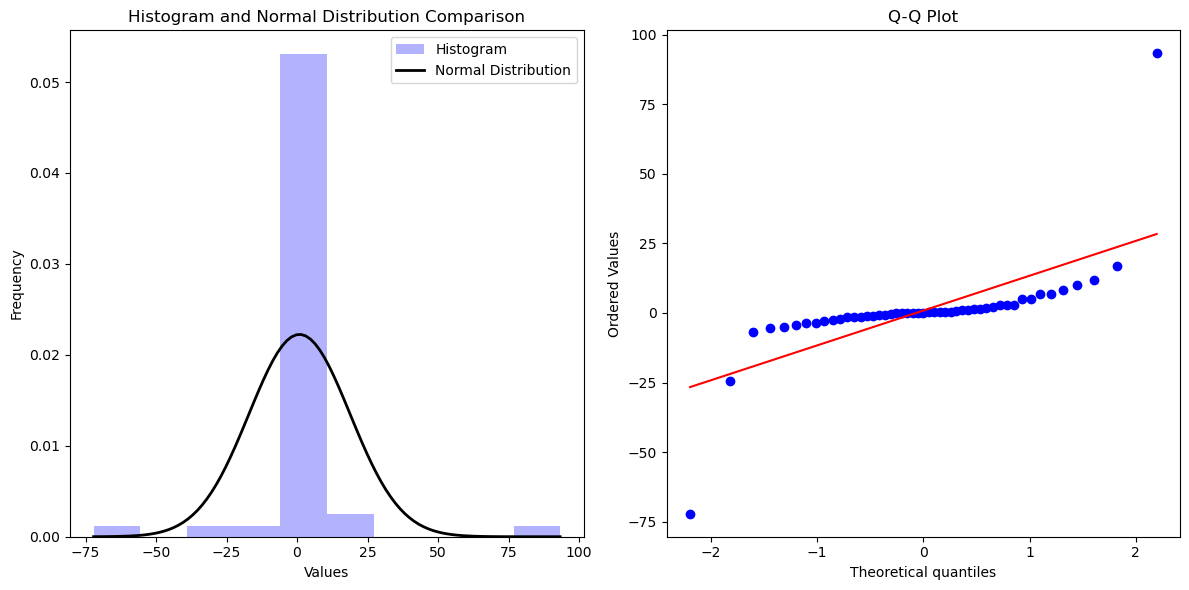

In [147]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, probplot, kurtosis, skew

# Calculate statistics
mean_data = statistical_performance_nifty_stocks_complied['Mean Profit'].mean()
std_dev_data = statistical_performance_nifty_stocks_complied['Mean Profit'].std()
kurtosis_data = kurtosis(statistical_performance_nifty_stocks_complied['Mean Profit'])
skewness_data = skew(statistical_performance_nifty_stocks_complied['Mean Profit'])

# Expected values for standard normal distribution
mean_standard_normal = 0
std_dev_standard_normal = 1
kurtosis_standard_normal = 0
skewness_standard_normal = 0

mean_difference = mean_data - mean_standard_normal
std_dev_difference = std_dev_data - std_dev_standard_normal
kurtosis_difference = kurtosis_data - kurtosis_standard_normal
skewness_difference = skewness_data - skewness_standard_normal

differences_df = pd.DataFrame({
    'Statistic': ['Mean', 'Standard Deviation', 'Kurtosis', 'Skewness'],
    'Difference': [mean_difference, std_dev_difference, kurtosis_difference, skewness_difference]
})

# Display DataFrame
print(differences_df)

# Plot histogram and normal distribution
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].hist(statistical_performance_nifty_stocks_complied['Mean Profit'], bins=10, density=True, alpha=0.3, color='b', label='Histogram')
x = np.linspace(statistical_performance_nifty_stocks_complied['Mean Profit'].min(), statistical_performance_nifty_stocks_complied['Mean Profit'].max(), 100)
p_data = norm.pdf(x, mean_data, std_dev_data)
axs[0].plot(x, p_data, 'k', linewidth=2, label='Normal Distribution')
axs[0].set_xlabel('Values')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Histogram and Normal Distribution Comparison')
axs[0].legend(loc='upper right')

# Q-Q plot
probplot(statistical_performance_nifty_stocks_complied['Mean Profit'], dist="norm", plot=axs[1], fit=True)
axs[1].set_title('Q-Q Plot')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


We will now perform similar analysis for the NSE Nifty 50 Index

In [148]:
nifty50_indices=['NIFTY']
set(nifty50_indices).issubset(ticker_list) # To check if the tickers are in the Option Data Universe

True

In [149]:
set_print=False
Overall_performance={}                      # This dictionary will store performance of each ticker using it as key
statistical_performance={}                  # This dictionary will store statistic behaviour of each ticker using it as key
from tqdm import tqdm
import yfinance as yf

for ticker in tqdm(nifty50_indices, desc="Processing", unit="ticker"):
    print(f'\n Start Building Symmteric Iron Condor Performance Charts for {ticker}\n ')
    performance=pd.DataFrame()
    market_data=yf.download('^NSEI',start='2022-01-01',end='2024-02-01')
    market_data['Returns']=market_data['Close'].pct_change()
    market_data['Trends']='Sideways'
    market_data.loc[market_data['Returns']>0.007,'Trends']='Bullish'
    market_data.loc[market_data['Returns']<-0.007,'Trends']='Bearish'

    expiries=get_expiry(ticker,framework=option_contracts_framework_2023)
    if set_print:
        print(market_data['Trends'].value_counts())

    # Initialize a list to store trend classifications for each expiry region
    expiry_trends = []

    # Iterate through the list of expiry timestamps
    flag=0
    for i in range(0,len(expiries)):
        # Define the start and end timestamps for the current expiry region
        if flag == 0:
            start_timestamp=datetime.strptime('2023-01-01', '%Y-%m-%d')
            end_timestamp = datetime.strptime('2023-01-25', '%Y-%m-%d')
            flag=flag+1
        else:
            start_timestamp = expiries[i-1]
            end_timestamp = expiries[i]
        
            
        start_date_of_expiry_series=start_timestamp
        try:
            specific_row = market_data.loc[start_date_of_expiry_series]
        except KeyError:
            # If the specific date is not found, find the next available date
            next_date = market_data.index[market_data.index > start_date_of_expiry_series][0]
            specific_row = market_data.loc[next_date]

        spot_price=int(specific_row['Close'])
        strike_list=option_chain(ticker=ticker,
                    expiry=get_expiry(ticker=ticker,framework=option_contracts_framework_2023)[i],
                    framework=option_contracts_framework_2023)['Strike']
        strike_list=[int(float(x)) for x in strike_list]
        ATM_strike = min(strike_list, key=lambda x: abs(x - spot_price))
        

        # Extract the market data for the current expiry region
        region_data = market_data.loc[(market_data.index >= start_timestamp) & (market_data.index < end_timestamp)]
        
        # Count the occurrences of each trend type in the current expiry region
        trend_counts = region_data['Trends'].value_counts()
        
        # Assign the trend with the maximum count as the trend for the current expiry region
        dominant_trend = trend_counts.idxmax()
        
        # Append the dominant trend for the current expiry region to the list
        expiry_trends.append((start_timestamp, end_timestamp, dominant_trend , ATM_strike))

    # Convert the list of expiry trends into a DataFrame for easier manipulation and analysis
    expiry_trends_df = pd.DataFrame(expiry_trends, columns=['Start of Expiry Series', 'End of Expiry Series', 'Trend', 'ATM Strike'])

    for expiry_date in tqdm(get_expiry(ticker=ticker,framework=option_contracts_framework_2023), desc="Processing", unit="expiry",position=0):
        #For a particular Expiry, deploy an Iron Condor at the begining of Option Monthly Expiry Series. and it is held till end of monthly expiry.
        try:
            df=option_contracts_framework_2023[(option_contracts_framework_2023['Ticker'] == ticker) & (option_contracts_framework_2023['Expiry Date'] == expiry_date)]
            df_PE=df[df['Type']=='PE']
            df_CE=df[df['Type']=='CE']
            df=pd.merge(df_CE,df_PE,on='Strike')
            df.drop(['Ticker_x','Asset Type_x','Ticker_y','Expiry Date_y','Asset Type_y'],axis=1,inplace=True)
            df.rename(columns={"Contract Names_x":"Call Contracts",
                                "Expiry Date_x":"Expiry Dates",
                                "Type_x":"CE",
                                "Contract Names_y":"Put Contracts",
                                "Type_y":"Type"},inplace=True)
            
            # Building Iron Condor

            # Selection the ITM Strike - middle value of list
            ATM_strike=expiry_trends_df[expiry_trends_df['End of Expiry Series']==expiry_date]['ATM Strike'].iloc[0]
            if set_print:
                print(ATM_strike)
                                                                                                            
            market_trend=expiry_trends_df[expiry_trends_df['End of Expiry Series']==expiry_date]['Trend'].iloc[0]
            if set_print:
                print(market_trend)

            df=option_chain(ticker=ticker,
                            expiry=expiry_date,
                            framework=option_contracts_framework_2023)
            df['Strike']=df['Strike'].astype(int)
            if set_print:
                print(df)
            df.index[df['Strike']==ATM_strike]
            # Selecting strike for legs of the Iron Condor
            put_short_strike=df['Strike'].loc[df.index[df['Strike']==ATM_strike][0]-3]           # Short OTM Put 3 strike away from ATM Strike
            call_short_strike=df['Strike'].loc[df.index[df['Strike']==ATM_strike][0]+3]          # Short OTM Call 3 strike away from ATM Strike
            put_long_strike=df['Strike'].loc[df.index[df['Strike']==ATM_strike][0]-6]            # Short DOTM Put 6 strike away from ATM Strike
            call_long_strike=df['Strike'].loc[df.index[df['Strike']==ATM_strike][0]+6]           # Short DOTM Call 6 strike away from ATM Strike

            if set_print:
                print(put_short_strike,call_short_strike,put_long_strike,call_long_strike)

            # Finding the name of contracts of Iron condor
            put_short_contract_name=df['Put Contracts'].loc[df.index[df['Strike']==ATM_strike][0]-3] 
            call_short_contract_name=df['Call Contracts'].loc[df.index[df['Strike']==ATM_strike][0]+3] 
            put_long_contract_name=df['Put Contracts'].loc[df.index[df['Strike']==ATM_strike][0]-6]  
            call_long_contract_name=df['Call Contracts'].loc[df.index[df['Strike']==ATM_strike][0]+6]  

            if set_print:
                print(put_short_contract_name,call_short_contract_name,put_long_contract_name,call_long_contract_name)

            # Getting Historical Data of selected contracts
            put_short_contract_data=get_data(root_folder=root_folder,filename=put_short_contract_name)['Close']
            call_short_contract_data=get_data(root_folder=root_folder,filename=call_short_contract_name)['Close']
            put_long_contract_data=get_data(root_folder=root_folder,filename=put_long_contract_name)['Close']
            call_long_contract_data=get_data(root_folder=root_folder,filename=call_long_contract_name)['Close']

            # combining all the premium data
            premium_data=pd.concat([put_short_contract_data,call_short_contract_data,put_long_contract_data,call_long_contract_data]
                                ,keys=['Put Short','Call Short','Put Long','Call Long'],axis=1).dropna()
            premium_data['Price of Iron Condor'] = np.round(premium_data['Put Short']+premium_data['Call Short'] - premium_data['Put Long']-premium_data['Call Long'],3)
            premium_data['Profit']=np.round(premium_data['Price of Iron Condor'].apply(lambda x : -x+premium_data['Price of Iron Condor'][0]),3)
            if set_print:
                print(premium_data)
            ticker_name=df['Call Contracts'][0][:df['Call Contracts'][0].find('23')]
            Profit=premium_data['Profit'][-1]
            Backtested_samples=premium_data.shape[0]
            Maxmium_profit=premium_data['Profit'].max()
            Percentage_duration_at_max_profit=(premium_data.index.get_loc(premium_data['Profit'].idxmax())+1)/len(premium_data)*100
            Expiry=expiry_date
            performance_df = pd.DataFrame({'Backtested Samples': Backtested_samples,
                                        'Profit till Expiry': Profit,
                                        'Maximum Profit':Maxmium_profit,
                                        'Duration % at Max Profit':np.round(Percentage_duration_at_max_profit,3),
                                        'Market Trend' :market_trend},index=[expiry_date.date()]).rename_axis('Expiry Date')

            performance = pd.concat([performance, performance_df])

            statistical_performance_df=pd.DataFrame({'Mean Profit':performance['Profit till Expiry'].mean(),
                                        'Std Profit':performance['Profit till Expiry'].std(),
                                        'Risk Adjusted Profit' : performance['Profit till Expiry'].mean()/performance['Profit till Expiry'].std(),
                                        'Mean Max Profit':performance['Maximum Profit'].mean(),},index=[ticker])

            Overall_performance[ticker]=performance
            statistical_performance[ticker]=statistical_performance_df
            
        except Exception as e:
            print(f"Error occurred for ticker : {ticker} for expiry date: {expiry_date.date()}, Error: {e}")

# It takes 2 minutes and 52 sec to complete processing

[*********************100%%**********************]  1 of 1 completed



 Start Building Symmteric Iron Condor Performance Charts for NIFTY
 


Processing:   0%|          | 0/52 [00:00<?, ?expiry/s]

Error occurred for ticker : NIFTY for expiry date: 2023-01-05, Error: single positional indexer is out-of-bounds


Processing:  21%|██        | 11/52 [00:28<01:45,  2.57s/expiry]

Error occurred for ticker : NIFTY for expiry date: 2023-03-23, Error: -3


Processing: 100%|██████████| 1/1 [02:24<00:00, 144.00s/ticker]


In [150]:
Overall_performance['NIFTY'].groupby('Market Trend').mean()

,Backtested Samples,Profit till Expiry,Maximum Profit,Duration % at Max Profit
Market Trend,,,,
Bearish,332.000000,24.650000,61.200000,12.349000
Bullish,293.333333,16.316667,37.733333,37.707667
Sideways,421.282609,-1.491304,27.153261,31.885978


In [151]:
statistical_performance['NIFTY']

,Mean Profit,Std Profit,Risk Adjusted Profit,Mean Max Profit
NIFTY,0.1,25.329075,0.003948,28.469


We can see from the above plot the the ditribution is skewed positively.

# Step 2 : Using Class Objects (OOP Concept) to make code more concise and repeatable for Iron Condor Analysis


We have carried step 1 analysis step-wise. We have used several functions in the process, however, several parameters needs to be change to check for new conditions. As we are going to check the Iron Condor performance for different lot size and different strikes, we need to encapsulate all the complexities using class objects and focusing on the input parameters only. 

We will be using function defined in step 1 to build following classes 
- Option_Data : This will manage all the data and methods for data manipulation 
- IronCondor  : This will evalute the performance of Iron Condor with different parameters.

In [10]:
# Importing Libraries required in the analysis
import os   
from datetime import datetime
from tqdm import tqdm
import pandas as pd
import numpy as np 
import yfinance as yf
     


In [40]:
class Option_Data:
    """
    This Class is used to give struture to the nested folders containing option data
    It is  used to store the Option Chain Data for Stock/Index Options.
    Class methods can build the Option Chain data for stocks/Index.
    Class methods can be used to retrive historical dvelopment of Stock/Index Options 
    """


    def __init__(self,root_folder_path):
        self.root_folder_path=root_folder_path
        self.get_contract_names()
        self.get_option_framework()

    def get_contract_names(self):
        """
        This method extracts all the contracts names present in the folder.
        These contracts are used to build option chain framework.
        Option Chain Framework -> Build Options Chain using information present in the contracts names
        """
        file_paths = []
        for _, _, files in os.walk(self.root_folder_path):
            for file in files:
                file_paths.append(file[:-4])           # Collect file paths in the nested folder structure

        self.contracts_name_dataframe=pd.DataFrame(file_paths,columns=['Contract Names'])
        return self.contracts_name_dataframe

    def get_option_framework(self):
        """ 
        This function build option chain framework from the contracts names. It is assumed that the option contract data is named after their 
        Ticker + Date of Expiry + Strike Price + Option Type 
        """
        #Extract the Ticker
        self.contracts_name_dataframe=self.get_contract_names()
        self.contracts_name_dataframe['Ticker']=self.contracts_name_dataframe['Contract Names'].apply(lambda x : (x[:x.find('2')]))
        #Extract the Expiry Date 
        self.contracts_name_dataframe['Expiry Date']=self.contracts_name_dataframe['Contract Names'].apply(lambda x : (x[x.find('2'):x.find('2')+6]))
        #Extract the Strike
        self.contracts_name_dataframe['Strike']=self.contracts_name_dataframe['Contract Names'].apply(lambda x : (x[x.find('2')+6:-2]))
        #Extract the Type - PE/CE
        self.contracts_name_dataframe['Type']=self.contracts_name_dataframe['Contract Names'].apply(lambda x: x[-2:])
        #Transformation of Expiry Date in correct format - %yy%mm%dd. This is followed throughout this project
        self.contracts_name_dataframe['Expiry Date']=self.contracts_name_dataframe['Expiry Date'].apply(lambda x : '20'+x)
        #Assign the Asset Type
        self.contracts_name_dataframe['Asset Type'] = np.where(self.contracts_name_dataframe['Expiry Date'].str.len() < 6, 'Commodity', 'Stocks/Index')
        #Selection of Only Stock.Index Options by Filtering Original Datframe and Saving it as new variable 'option_self.contracts_name_dataframe'
        self.option_contracts_dataframe=self.contracts_name_dataframe[self.contracts_name_dataframe['Asset Type']=='Stocks/Index'].copy()
        #Converting the Expiry Date Column into datetime format
        self.option_contracts_dataframe['Expiry Date']=self.option_contracts_dataframe['Expiry Date'].apply(lambda x : datetime.strptime(x,'%Y%m%d'))

        return self.option_contracts_dataframe    
    
    def get_expiry(self,ticker,year=2023):
        """
        This method extracts all the expiry dates in the year 2023
        Year: For expiries in all years , Set it False 
        """
        # Extract list of all Expiry Dates for a particular ticker
        expiry_dates_list=list(set(self.option_contracts_dataframe[self.option_contracts_dataframe['Ticker']==ticker]['Expiry Date']))
        # Filtering Expiry Dates for Year 2023
        if year:
            expiry_dates_list = [date for date in expiry_dates_list if date.year == year]

        return np.sort(expiry_dates_list).tolist()

        
    def get_ticker_list(self,):
        ticker_list=sorted(set(self.option_contracts_dataframe['Ticker']))
        return list(ticker_list)
    

    def get_option_chain(self,ticker,expiry):
        # Filter dataframe with ticker symbol and Expiry Date
        df=self.option_contracts_dataframe[(self.option_contracts_dataframe['Ticker'] == ticker) & (self.option_contracts_dataframe['Expiry Date'] == expiry)]
        # Extracting the PE Side and CE Side of the DataFrame to Merge them Horizontally on the Strike Price
        df_PE=df[df['Type']=='PE']
        df_CE=df[df['Type']=='CE']
        df=pd.merge(df_CE,df_PE,on='Strike')
        # Removing, Renaming and Re-Arranging the Columns to build Option Chain Structure

        #Removing unncessary columns 
        df.drop(['Ticker_x','Asset Type_x','Ticker_y','Expiry Date_y','Asset Type_y'],axis=1,inplace=True)
        #Renaming the columns
        df.rename(columns={"Contract Names_x":"Call Contracts",
                            "Expiry Date_x":"Expiry Dates",
                            "Type_x":"CE",
                            "Contract Names_y":"Put Contracts",
                            "Type_y":"PE"},inplace=True)
        #Rearranging the columns
        df=df[['Expiry Dates','CE','Call Contracts','Strike','Put Contracts','PE']]
        return df
        

    def list_month_folders(self):
        """
        This Fucntion will find the list of all the folders having monthly tick by tick data
        The struture of folders are assumed to be
        - 2023
            - Jan 2023
                - abc1.csv
                - abc2.csv
                - abc3.csv  
            - Feb 2023 
            ....
            ....
            - Dec 2023 
        """

        folders = []                                        # for storing folder paths 
        for item in os.listdir(self.root_folder_path):                
            # Folder structure has 2 level, root folder path and folder inside the root folder, so single iteration is enough
            item_path = os.path.join(root_folder, item)
            # if os.path.isdir(item_path):                  # Check 
            folders.append(item_path)
        return folders

    def get_historical_data(self,contract_name):
        """
        This function trasverse all the nested folders and searches for the contract name and concat csv files 
        with same name on a single dataframe object. 
        """
        filename=contract_name+'.csv'
        month_folders=list_month_folders(root_folder)           # Saving Folder names
        # print(month_folders)                                  # This is used to see the output of months folders path 

        df=pd.DataFrame()
        for month_folder in month_folders:
            for foldername, _, filenames in os.walk(month_folder):
                if filename in filenames:
                    file_path = os.path.join(foldername, filename)  # Build path for all .csv files having input contract name
                    with open(file_path, 'r') as file:
                        data = pd.read_csv(file)
                        # Issue - > After merger only common datetime index remains. Can be inproved later stage.
                        df=pd.concat([df,data],axis=0)              # concat all csv files with input contract name 

        df.rename(columns={'<ticker>':'Ticker',                     # rename the columns of Datframe. 
                        '<date>':'Date',
                        '<time>':'Time',
                        '<open>':'Open',
                        '<high>':'High',
                        '<low>':'Low',
                        '<close>':'Close',
                        '<volume>':'Volume',
                        '<o/i>':'OI'}
                        ,inplace=True)
        df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'],format='mixed')   # Build Datetime column to be used as Index as data is of 1 minute TimeFrame - > Both Date and Time are important. 
        df.set_index(['Datetime'],inplace=True)
        df.sort_index(inplace=True)

        # Resampling the Data to 15 minute TimeFrame, which is used by Institutional Trading
        df=df.resample('15T').last()                                # Taking the Closing Price in 15 minute TimeFrame
        return df


    def get_market_data_and_trends(self,ticker,expiry,start='2022-01-01',end='2024-02-01'):
        """ 
        This method looks for the ATM strike price on the day of start of new expiry.
        Also this method checks the Market Trend. This will be useful to see if Iron Condor performance under different market condition. 
          
        """
        if ticker=='NIFTY':
            market_data=yf.download('^NSEI',start=start,end=end)
        else:
            market_data=yf.download(ticker+'.NS',start=start,end=end)
        market_data['Returns']=market_data['Close'].pct_change()
        market_data['Trends']='Sideways'
        market_data.loc[market_data['Returns']>0.007,'Trends']='Bullish'
        market_data.loc[market_data['Returns']<-0.007,'Trends']='Bearish'

        expiries=self.get_expiry(ticker)
        # print(market_data['Trends'].value_counts())

        # Initialize a list to store trend classifications for each expiry region
        expiry_trends = []

        # Iterate through the list of expiry timestamps
        flag=0
        for i in range(0,len(expiries) - 1):
            # Define the start and end timestamps for the current expiry region
            if flag == 0:
                start_timestamp=datetime.strptime('2023-01-01', '%Y-%m-%d')
                end_timestamp = datetime.strptime('2023-01-25', '%Y-%m-%d')
                flag=flag+1
            else:
                start_timestamp = expiries[i-1]
                end_timestamp = expiries[i]
            

                    
            start_date_of_expiry_series=start_timestamp
            try:
                specific_row = market_data.loc[start_date_of_expiry_series]
            except KeyError:
                # If the specific date is not found, find the next available date
                next_date = market_data.index[market_data.index > start_date_of_expiry_series][0]
                specific_row = market_data.loc[next_date]

            spot_price=int(specific_row['Close'])
            strike_list=self.get_option_chain(ticker,expiry)['Strike']
            strike_list=[int(x) for x in strike_list]

            ATM_strike = min(strike_list, key=lambda x: abs(x - spot_price))
            

            # Extract the market data for the current expiry region
            region_data = market_data.loc[(market_data.index >= start_timestamp) & (market_data.index < end_timestamp)]
            
            # Count the occurrences of each trend type in the current expiry region
            trend_counts = region_data['Trends'].value_counts()
            
            # Assign the trend with the maximum count as the trend for the current expiry region
            dominant_trend = trend_counts.idxmax()
            
            # Append the dominant trend for the current expiry region to the list
            expiry_trends.append((start_timestamp, end_timestamp, dominant_trend , ATM_strike))

        # Convert the list of expiry trends into a DataFrame for easier manipulation and analysis
        expiry_trends_df = pd.DataFrame(expiry_trends, columns=['Start of Expiry Series', 'End of Expiry Series', 'Trend', 'ATM Strike'])

        return expiry_trends_df


In [84]:
class IronCondor:
    """
    This Class implement the Iron Condor Strategy on the Option Chain (Monthly/Weekly) and evaluates Performance
       
    """

    def __init__(self,tickers,root_folder_path,lot_size=[1,1,1,1],type='Symmteric',strike_offset_for_long_put=6,set_print=False):
        self.set_print=set_print
        self.Overall_performance={}           # This dictionary will store performance of each ticker using it as key
        self.statistical_performance={}       # This dictionary will store statistic behaviour of each ticker using it as key
        self.tickers=tickers
        self.lot_size=lot_size
        self.type=type
        self.strike_offset_for_long_put=strike_offset_for_long_put
        self.root_folder_path=root_folder_path
        self.Option_Data=Option_Data(root_folder_path=root_folder_path)

        if self.type not in ['Symmetric', 'Asymmetric']:
            raise ValueError("Invalid Iron Condor category. Please choose either 'Symmetric' or 'Asymmetric'.")


    
    def list_month_folders(self,root_folder):
        """
        This Fucntion will find the list of all the folders having monthly tick by tick data
        The struture of folders are assumed to be
        - 2023
            - Jan 2023
                - abc1.csv
                - abc2.csv
                - abc3.csv  
            - Feb 2023 
            ....
            ....
            - Dec 2023 
        """

        folders = []                                        # for storing folder paths 
        for item in os.listdir(self.root_folder_path):                
            # Folder structure has 2 level, root folder path and folder inside the root folder, so single iteration is enough
            item_path = os.path.join(root_folder, item)
            # if os.path.isdir(item_path):                  # Check 
            folders.append(item_path)
        return folders


    def get_historical_data(self,contract_name):
        """
        This function trasverse all the nested folders and searches for the contract name and concat csv files 
        with same name on a single dataframe object. 
        """
        filename=contract_name+'.csv'
        month_folders=self.list_month_folders(root_folder)           # Saving Folder names

        df=pd.DataFrame()
        for month_folder in month_folders:
            for foldername, _, filenames in os.walk(month_folder):
                if filename in filenames:
                    file_path = os.path.join(foldername, filename)  # Build path for all .csv files having input contract name
                    with open(file_path, 'r') as file:
                        data = pd.read_csv(file)
                        # Issue - > After merger only common datetime index remains. Can be inproved later stage.
                        df=pd.concat([df,data],axis=0)              # concat all csv files with input contract name 

        df.rename(columns={'<ticker>':'Ticker',                     # rename the columns of Datframe. 
                        '<date>':'Date',
                        '<time>':'Time',
                        '<open>':'Open',
                        '<high>':'High',
                        '<low>':'Low',
                        '<close>':'Close',
                        '<volume>':'Volume',
                        '<o/i>':'OI'}
                        ,inplace=True)
        df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'],format='mixed')   # Build Datetime column to be used as Index as data is of 1 minute TimeFrame - > Both Date and Time are important. 
        df.set_index(['Datetime'],inplace=True)
        df.sort_index(inplace=True)

        # Resampling the Data to 15 minute TimeFrame, which is used by Institutional Trading
        df=df.resample('15T').last()                                # Taking the Closing Price in 15 minute TimeFrame
        return df
        


    def construct_iron_condor(self,ticker,expiry_date):
        expiry_trends_df = self.Option_Data.get_market_data_and_trends(ticker,expiry_date)
        ATM_strike=expiry_trends_df[expiry_trends_df['End of Expiry Series']==expiry_date]['ATM Strike'].iloc[0]
        self.market_trend=expiry_trends_df[expiry_trends_df['End of Expiry Series']==expiry_date]['Trend'].iloc[0]
        df=self.Option_Data.get_option_chain(ticker=ticker,expiry=expiry_date)
        df['Strike']=df['Strike'].astype(int)
        if self.set_print:
            print(df)
        df.index[df['Strike']==ATM_strike]

        # Selecting strike for legs of the Iron Condor
        if self.type=='Symmetric':
            put_short_strike=df['Strike'].loc[df.index[df['Strike']==ATM_strike][0]-3]           # Short OTM Put 3 strike away from ATM Strike
            call_short_strike=df['Strike'].loc[df.index[df['Strike']==ATM_strike][0]+3]          # Short OTM Call 3 strike away from ATM Strike
            put_long_strike=df['Strike'].loc[df.index[df['Strike']==ATM_strike][0]-6]            # Short DOTM Put 6 strike away from ATM Strike
            call_long_strike=df['Strike'].loc[df.index[df['Strike']==ATM_strike][0]+6]           # Short DOTM Call 6 strike away from ATM Strike

            # Finding the name of contracts of Iron condor
            put_short_contract_name=df['Put Contracts'].loc[df.index[df['Strike']==ATM_strike][0]-3] 
            call_short_contract_name=df['Call Contracts'].loc[df.index[df['Strike']==ATM_strike][0]+3] 
            put_long_contract_name=df['Put Contracts'].loc[df.index[df['Strike']==ATM_strike][0]-6]  
            call_long_contract_name=df['Call Contracts'].loc[df.index[df['Strike']==ATM_strike][0]+6]


        else :
            put_short_strike=df['Strike'].loc[df.index[df['Strike']==ATM_strike][0]-3]                                  # Short OTM Put 3 strike away from ATM Strike
            call_short_strike=df['Strike'].loc[df.index[df['Strike']==ATM_strike][0]+3]                                 # Short OTM Call 3 strike away from ATM Strike
            put_long_strike=df['Strike'].loc[df.index[df['Strike']==ATM_strike][0]-self.strike_offset_for_long_put]     # Short DOTM Put 6 strike away from ATM Strike
            call_long_strike=df['Strike'].loc[df.index[df['Strike']==ATM_strike][0]+6]                                  # Short DOTM Call 6 strike away from ATM Strike

            # Finding the name of contracts of Iron condor
            put_short_contract_name=df['Put Contracts'].loc[df.index[df['Strike']==ATM_strike][0]-3] 
            call_short_contract_name=df['Call Contracts'].loc[df.index[df['Strike']==ATM_strike][0]+3] 
            put_long_contract_name=df['Put Contracts'].loc[df.index[df['Strike']==ATM_strike][0]-self.strike_offset_for_long_put]  
            call_long_contract_name=df['Call Contracts'].loc[df.index[df['Strike']==ATM_strike][0]+6]

                  
     
        # Getting Historical Data of selected contracts
        put_short_contract_data=self.get_historical_data(contract_name=put_short_contract_name)['Close']
        call_short_contract_data=self.get_historical_data(contract_name=call_short_contract_name)['Close']
        put_long_contract_data=self.get_historical_data(contract_name=put_long_contract_name)['Close']
        call_long_contract_data=self.get_historical_data(contract_name=call_long_contract_name)['Close']

        # combining all the premium data
        premium_data=pd.concat([put_short_contract_data,call_short_contract_data,put_long_contract_data,call_long_contract_data]
                                        ,keys=['Put Short','Call Short','Put Long','Call Long'],axis=1).dropna()
        premium_data['Price of Iron Condor'] = np.round(self.lot_size[0]*premium_data['Put Short']+self.lot_size[1]*premium_data['Call Short'] - self.lot_size[2]*premium_data['Put Long']-self.lot_size[3]*premium_data['Call Long'],3)
        premium_data['Profit']=np.round(premium_data['Price of Iron Condor'].apply(lambda x : -x+premium_data['Price of Iron Condor'][0]),3)

        if self.set_print:
            print(put_short_strike,call_short_strike,put_long_strike,call_long_strike)
            print(put_short_contract_name,call_short_contract_name,put_long_contract_name,call_long_contract_name)
            print(premium_data)

        return premium_data
    



    def calculate_iron_condor_performance(self):
        self.overall_performance={}
        self.statistical_performance={}
        self.overall_historical_performance={}
        for ticker in tqdm(self.tickers, desc="Processing", unit="ticker",position=0):
            print(f'\n Start Building Symmteric Iron Condor Performance Charts for {ticker}\n ')
            self.performance=pd.DataFrame()
            self.historical_performance_df=pd.DataFrame()
            self.statistical_performance_df=pd.DataFrame()

        
            for expiry_date in tqdm(self.Option_Data.get_expiry(ticker=ticker,year=2023), desc="Processing", unit="expiry"):
                #For a particular Expiry, deploy an Iron Condor at the begining of Option Monthly Expiry Series. and it is held till end of monthly expiry.
                try:
                    self.premium_data=self.construct_iron_condor(ticker=ticker,expiry_date=expiry_date)
                    # ticker_name=df['Call Contracts'][0][:df['Call Contracts'][0].find('23')]                 
                    self.historical_performance=pd.DataFrame(self.premium_data['Profit'])
                    self.historical_performance.rename(columns={'Profit':expiry_date},inplace=True)
                    self.Profit=self.premium_data['Profit'][-1]
                    self.Backtested_samples=self.premium_data.shape[0]
                    self.Maxmium_profit=self.premium_data['Profit'].max()
                    self.Percentage_duration_at_max_profit=(self.premium_data.index.get_loc(self.premium_data['Profit'].idxmax())+1)/len(self.premium_data)*100
                    self.Expiry=expiry_date
                    self.performance_df = pd.DataFrame({'Backtested Samples': self.Backtested_samples,
                                                'Profit till Expiry': self.Profit,
                                                'Maximum Profit':self.Maxmium_profit,
                                                'Duration % at Max Profit':np.round(self.Percentage_duration_at_max_profit,3),
                                                'Market Trend' :self.market_trend},index=[expiry_date.date()]).rename_axis('Expiry Date')

                    self.performance = pd.concat([self.performance, self.performance_df])

                    if self.historical_performance.shape[0] !=0:
                        self.historical_performance_df=pd.concat([self.historical_performance_df,self.historical_performance],axis=1)


                    self.overall_performance[ticker]=self.performance

                    self.overall_historical_performance[ticker]=self.historical_performance_df

                    self.statistical_performance_df=pd.DataFrame({'Mean Profit':self.performance['Profit till Expiry'].mean(),
                                                    'Std Profit':self.performance['Profit till Expiry'].std(),
                                                    'Risk Adjusted Profit' : self.performance['Profit till Expiry'].mean()/self.performance['Profit till Expiry'].std(),
                                                    'Mean Max Profit':self.performance['Maximum Profit'].mean()},index=[ticker])

                    self.statistical_performance[ticker]=self.statistical_performance_df
                
                
                except Exception as e:
                    print(f"Error occurred for ticker : {ticker} for expiry date: {expiry_date.date()}, Error: {e}")


        return self.overall_performance,self.statistical_performance,self.overall_historical_performance
    



In [85]:
SBI_condor=IronCondor(tickers=['SBIN'],root_folder_path=root_folder,type='Symmetric')


In [86]:
SBI_condor.calculate_iron_condor_performance()

Processing:   0%|          | 0/1 [00:00<?, ?ticker/s]


 Start Building Symmteric Iron Condor Performance Charts for SBIN
 


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Processing: 100%|██████████| 1/1 [00:33<00:00, 33.16s/ticker]

Error occurred for ticker : SBIN for expiry date: 2023-12-28, Error: single positional indexer is out-of-bounds


({'SBIN':              Backtested Samples  Profit till Expiry  Maximum Profit  \
  Expiry Date                                                           
  2023-01-25                  409               -8.55            7.30   
  2023-02-23                  276                0.45            5.10   
  2023-03-29                  612                2.40            2.40   
  2023-04-27                  356                0.65            2.35   
  2023-05-25                  576               -4.15            1.25   
  2023-06-29                  949                0.00            0.00   
  2023-07-27                  595                0.00            0.00   
  2023-08-31                  651                2.15            2.65   
  2023-09-28                  480                1.30            1.60   
  2023-10-26                  764                1.25            4.90   
  2023-11-30                  259               -0.50            2.50   
  
               Duration % at Max Profit 

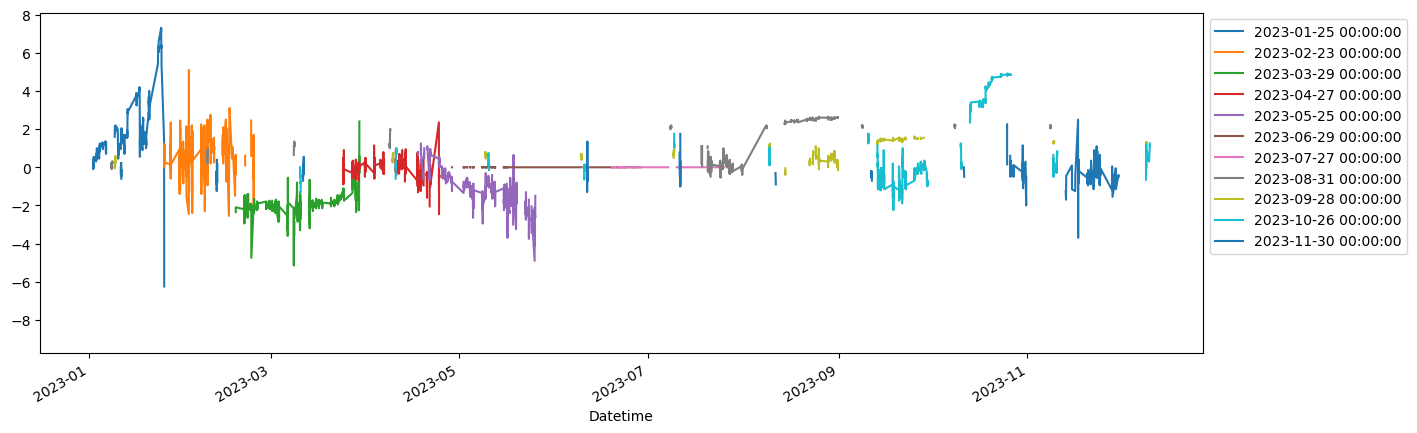

In [87]:
ax = SBI_condor.historical_performance_df.plot(figsize=(15,5))
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))


In [ ]:
import yfinance as yf
import matplotlib.pyplot as plt

sbi_data = yf.download('SBIN.NS', start='2023-01-01', end='2024-01-01')
fig, ax1 = plt.subplots(figsize=(15, 5))
SBI_condor.historical_performance_df.plot(ax=ax1,alpha=0.5)

ax2 = ax1.twinx()
sbi_data['Close'].plot(ax=ax2, color='red', label='SBIN Closing Price')
ax1.set_ylabel('Historical Performance')
ax2.set_ylabel('SBIN Price')
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left', bbox_to_anchor=(1.1, 1))
plt.show()



In [ ]:
SBI_condor=IronCondor(root_folder_path=root_folder,tickers=['SBIN'],lot_size=[1,1,2,1],type='Asymmetric',strike_offset_for_long_put=8)
SBI_condor.calculate_iron_condor_performance()
SBI_condor.statistical_performance['SBIN']

# Step 3 : Comparison of Iron Condor With and W/o Extra Long put for different combinations

### Comparison of Profit and Loss for Iron Condor with Extra Long Put with different Strikes
#### 1 Lots of all options are used to build Iron Condor
- Symmetric Iron Condor
- Asymmetric Iron Condor with Extra Long Put with 8 strike offset
- Asymmetric Iron Condor with Exta Long Put with 12 strike offset
- Asymmetric Iron Condor with Exta Long Put with 16 strike offset
- Asymmetric Iron Condor with Exta Long Put with 20 strike offset



In [91]:
nifty_condor_symmteric = IronCondor(tickers=['NIFTY'], root_folder_path=root_folder, lot_size=[1,1,1,1], type='Symmetric')
nifty_condor_symmteric.calculate_iron_condor_performance()

nifty_condor_asymmetric_8_offset = IronCondor(tickers=['NIFTY'], root_folder_path=root_folder, lot_size=[1,1,1,1], type='Asymmetric',strike_offset_for_long_put=8)
nifty_condor_asymmetric_8_offset.calculate_iron_condor_performance()


nifty_condor_asymmetric_12_offset = IronCondor(tickers=['NIFTY'], root_folder_path=root_folder, lot_size=[1,1,1,1], type='Asymmetric',strike_offset_for_long_put=12)
nifty_condor_asymmetric_12_offset.calculate_iron_condor_performance()


nifty_condor_asymmetric_16_offset = IronCondor(tickers=['NIFTY'], root_folder_path=root_folder, lot_size=[1,1,1,1], type='Asymmetric',strike_offset_for_long_put=16)
nifty_condor_asymmetric_16_offset.calculate_iron_condor_performance()

nifty_condor_asymmetric_20_offset = IronCondor(tickers=['NIFTY'], root_folder_path=root_folder, lot_size=[1,1,1,1], type='Asymmetric',strike_offset_for_long_put=20)
nifty_condor_asymmetric_20_offset.calculate_iron_condor_performance()



Processing:   0%|          | 0/1 [00:00<?, ?ticker/s]


 Start Building Symmteric Iron Condor Performance Charts for NIFTY
 


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Error occurred for ticker : NIFTY for expiry date: 2023-01-05, Error: single positional indexer is out-of-bounds



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Error occurred for ticker : NIFTY for expiry date: 2023-03-23, Error: -3



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

Error occurred for ticker : NIFTY for expiry date: 2023-12-28, Error: single positional indexer is out-of-bounds



Processing:   0%|          | 0/1 [00:00<?, ?ticker/s]


 Start Building Symmteric Iron Condor Performance Charts for NIFTY
 


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Error occurred for ticker : NIFTY for expiry date: 2023-01-05, Error: single positional indexer is out-of-bounds



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Error occurred for ticker : NIFTY for expiry date: 2023-03-23, Error: -3



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

Error occurred for ticker : NIFTY for expiry date: 2023-12-28, Error: single positional indexer is out-of-bounds



Processing:   0%|          | 0/1 [00:00<?, ?ticker/s]


 Start Building Symmteric Iron Condor Performance Charts for NIFTY
 


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Error occurred for ticker : NIFTY for expiry date: 2023-01-05, Error: single positional indexer is out-of-bounds



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Error occurred for ticker : NIFTY for expiry date: 2023-03-23, Error: -3



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

Error occurred for ticker : NIFTY for expiry date: 2023-12-28, Error: single positional indexer is out-of-bounds



Processing:   0%|          | 0/1 [00:00<?, ?ticker/s]


 Start Building Symmteric Iron Condor Performance Charts for NIFTY
 


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Error occurred for ticker : NIFTY for expiry date: 2023-01-05, Error: single positional indexer is out-of-bounds



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Error occurred for ticker : NIFTY for expiry date: 2023-03-23, Error: -3



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

Error occurred for ticker : NIFTY for expiry date: 2023-12-28, Error: single positional indexer is out-of-bounds



Processing:   0%|          | 0/1 [00:00<?, ?ticker/s]


 Start Building Symmteric Iron Condor Performance Charts for NIFTY
 


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Error occurred for ticker : NIFTY for expiry date: 2023-01-05, Error: single positional indexer is out-of-bounds



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Error occurred for ticker : NIFTY for expiry date: 2023-03-23, Error: -3



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

Error occurred for ticker : NIFTY for expiry date: 2023-12-28, Error: single positional indexer is out-of-bounds


({'NIFTY':              Backtested Samples  Profit till Expiry  Maximum Profit  \
  Expiry Date                                                           
  2023-01-12                  225              128.55          128.55   
  2023-01-19                  252               33.05           88.60   
  2023-01-25                  451               75.15          217.35   
  2023-02-02                  321              -98.90           46.85   
  2023-02-09                  256               16.05           18.25   
  2023-02-16                  312               74.30           79.35   
  2023-02-23                  803             -107.05           29.85   
  2023-03-02                  380              -93.75           29.30   
  2023-03-09                  244               19.45           23.65   
  2023-03-16                  303              -92.60           46.90   
  2023-03-29                  698              -11.15           11.20   
  2023-04-06                  323         

In [98]:
dfs = [
    np.round(nifty_condor_symmteric.overall_performance['NIFTY'].groupby('Market Trend').mean(), 2),
    np.round(nifty_condor_asymmetric_8_offset.overall_performance['NIFTY'].groupby('Market Trend').mean(), 2),
    np.round(nifty_condor_asymmetric_12_offset.overall_performance['NIFTY'].groupby('Market Trend').mean(), 2),
    np.round(nifty_condor_asymmetric_16_offset.overall_performance['NIFTY'].groupby('Market Trend').mean(), 2),
    np.round(nifty_condor_asymmetric_20_offset.overall_performance['NIFTY'].groupby('Market Trend').mean(), 2)
]

names = ['symmetric', 'asymmetric_8_offset', 'asymmetric_12_offset', 'asymmetric_16_offset', 'asymmetric_20_offset']

concatenated_dfs = pd.concat([df.rename(columns={'Value': name}) for df, name in zip(dfs, names)], keys=names)
concatenated_dfs


Backtested Samples  Profit till Expiry  \
                     Market Trend                                           
symmetric            Bearish                   332.00               24.65   
                     Bullish                   293.33               16.32   
                     Sideways                  419.38               -1.52   
asymmetric_8_offset  Bearish                   332.00               24.65   
                     Bullish                   294.33               27.73   
                     Sideways                  419.20                1.42   
asymmetric_12_offset Bearish                   317.00              -13.90   
                     Bullish                   295.33               65.72   
                     Sideways                  417.76               13.66   
asymmetric_16_offset Bearish                   332.00              -48.25   
                     Bullish                   296.67               98.42   
                     Sideways                  411.80               21.59   
asymmetric_20_offset Bearish                   303.00              -92.60   
                     Bullish                   295.00              135.05   
                     Sideways                  402.67               30.06   

                                   Maximum Profit  Duration % at Max Profit  
                     Market Trend                                            
symmetric            Bearish                61.20                     12.35  
                     Bullish                37.73                     37.71  
                     Sideways               27.76                     32.59  
asymmetric_8_offset  Bearish                61.20                     12.35  
                     Bullish                49.17                     37.60  
                     Sideways               33.68                     34.36  
asymmetric_12_offset Bearish                70.90                      0.95  
                     Bullish                79.25                     66.39  
                     Sideways               43.93                     54.17  
asymmetric_16_offset Bearish                46.10                     42.47  
                     Bullish               107.12                     66.59  
                     Sideways               52.06                     64.61  
asymmetric_20_offset Bearish                46.90                     36.96  
                     Bullish               140.72                     94.36  
                     Sideways               65.76                     68.24

In [104]:
dfs = [
    np.round(nifty_condor_symmteric.statistical_performance['NIFTY'], 3),
    np.round(nifty_condor_asymmetric_8_offset.statistical_performance['NIFTY'], 3),
    np.round(nifty_condor_asymmetric_12_offset.statistical_performance['NIFTY'], 3),
    np.round(nifty_condor_asymmetric_16_offset.statistical_performance['NIFTY'], 3),
    np.round(nifty_condor_asymmetric_20_offset.statistical_performance['NIFTY'], 3)
]

names = ['symmetric', 'asymmetric_8_offset', 'asymmetric_12_offset', 'asymmetric_16_offset', 'asymmetric_20_offset']

concatenated_dfs = pd.concat([df.rename(columns={'Value': name}) for df, name in zip(dfs, names)], keys=names)
concatenated_dfs


,,Mean Profit,Std Profit,Risk Adjusted Profit,Mean Max Profit
symmetric,NIFTY,0.102,25.592,0.004,29.050
asymmetric_8_offset,NIFTY,3.509,28.414,0.124,35.186
asymmetric_12_offset,NIFTY,16.288,34.863,0.467,46.641
asymmetric_16_offset,NIFTY,24.866,47.228,0.527,55.311
asymmetric_20_offset,NIFTY,33.983,62.809,0.541,69.968


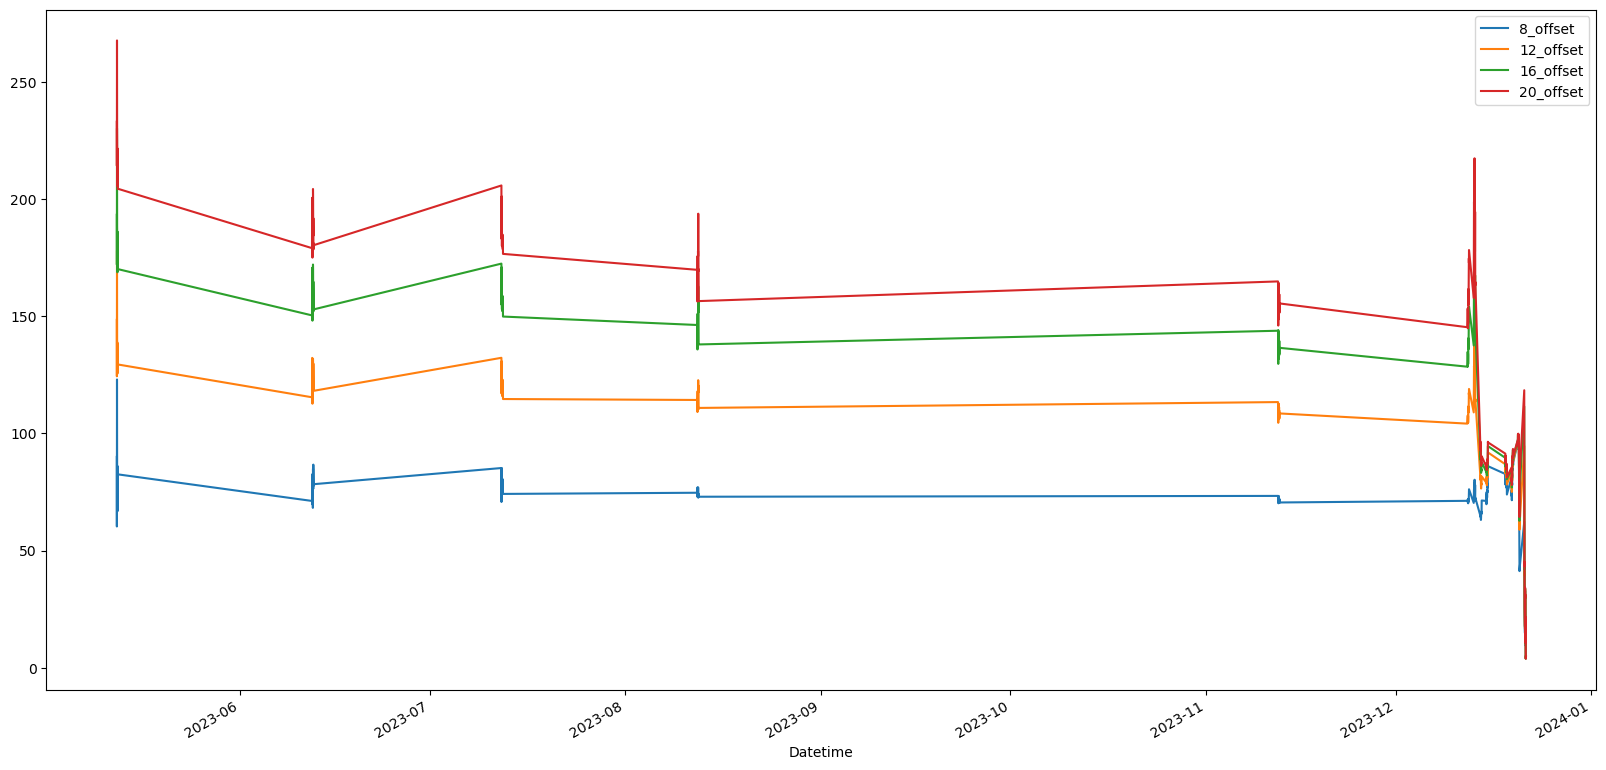

In [93]:
# Price of Iron Condor
nifty_condor_asymmetric_8_offset.premium_data['Price of Iron Condor'].plot(figsize=(20,10),label='8_offset')
nifty_condor_asymmetric_12_offset.premium_data['Price of Iron Condor'].plot(figsize=(20,10),label='12_offset')
nifty_condor_asymmetric_16_offset.premium_data['Price of Iron Condor'].plot(figsize=(20,10),label='16_offset')
nifty_condor_asymmetric_20_offset.premium_data['Price of Iron Condor'].plot(figsize=(20,10),label='20_offset')

plt.legend()


### Comparison of Greeks for IC with different Lot Size of Long Put
- Symmetric Iron Condor
- Asymmetric Iron Condor with Extra Long Put with lot size =1 
- Asymmetric Iron Condor with Exta Long Put with lot size = 2 
- Asymmetric Iron Condor with Exta Long Put with lot size = 4 
- Asymmetric Iron Condor with Exta Long Put with lot size = 8



In [106]:
nifty_condor_symmteric = IronCondor(tickers=['NIFTY'], root_folder_path=root_folder, lot_size=[1,1,1,1], type='Symmetric')
nifty_condor_symmteric.calculate_iron_condor_performance()

nifty_condor_asymmetric_1_lot = IronCondor(tickers=['NIFTY'], root_folder_path=root_folder, lot_size=[1,1,1,1], type='Asymmetric',strike_offset_for_long_put=8)
nifty_condor_asymmetric_1_lot.calculate_iron_condor_performance()

nifty_condor_asymmetric_2_lot = IronCondor(tickers=['NIFTY'], root_folder_path=root_folder, lot_size=[1,1,2,1], type='Asymmetric',strike_offset_for_long_put=8)
nifty_condor_asymmetric_2_lot.calculate_iron_condor_performance()

nifty_condor_asymmetric_4_lot = IronCondor(tickers=['NIFTY'], root_folder_path=root_folder, lot_size=[1,1,4,1], type='Asymmetric',strike_offset_for_long_put=8)
nifty_condor_asymmetric_4_lot.calculate_iron_condor_performance()





Processing:   0%|          | 0/1 [00:00<?, ?ticker/s]


 Start Building Symmteric Iron Condor Performance Charts for NIFTY
 


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Error occurred for ticker : NIFTY for expiry date: 2023-01-05, Error: single positional indexer is out-of-bounds



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Error occurred for ticker : NIFTY for expiry date: 2023-03-23, Error: -3



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

Error occurred for ticker : NIFTY for expiry date: 2023-12-28, Error: single positional indexer is out-of-bounds



Processing:   0%|          | 0/1 [00:00<?, ?ticker/s]


 Start Building Symmteric Iron Condor Performance Charts for NIFTY
 


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Error occurred for ticker : NIFTY for expiry date: 2023-01-05, Error: single positional indexer is out-of-bounds



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Error occurred for ticker : NIFTY for expiry date: 2023-03-23, Error: -3



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

Error occurred for ticker : NIFTY for expiry date: 2023-12-28, Error: single positional indexer is out-of-bounds



Processing:   0%|          | 0/1 [00:00<?, ?ticker/s]


 Start Building Symmteric Iron Condor Performance Charts for NIFTY
 


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Error occurred for ticker : NIFTY for expiry date: 2023-01-05, Error: single positional indexer is out-of-bounds



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Error occurred for ticker : NIFTY for expiry date: 2023-03-23, Error: -3



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

Error occurred for ticker : NIFTY for expiry date: 2023-12-28, Error: single positional indexer is out-of-bounds



Processing:   0%|          | 0/1 [00:00<?, ?ticker/s]


 Start Building Symmteric Iron Condor Performance Charts for NIFTY
 


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Error occurred for ticker : NIFTY for expiry date: 2023-01-05, Error: single positional indexer is out-of-bounds



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Error occurred for ticker : NIFTY for expiry date: 2023-03-23, Error: -3



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

Error occurred for ticker : NIFTY for expiry date: 2023-12-28, Error: single positional indexer is out-of-bounds


({'NIFTY':              Backtested Samples  Profit till Expiry  Maximum Profit  \
  Expiry Date                                                           
  2023-01-12                  228               16.45           46.60   
  2023-01-19                  330             -102.35           60.80   
  2023-01-25                  452             -414.85          172.90   
  2023-02-02                  350             -112.75          431.55   
  2023-02-09                  258             -206.55          506.35   
  2023-02-16                  317             -532.45          749.15   
  2023-02-23                  762              453.95          812.30   
  2023-03-02                  378             -145.00          107.70   
  2023-03-09                  254             -134.30          174.80   
  2023-03-16                  332             1139.00         1482.95   
  2023-03-29                  714             -579.05          178.80   
  2023-04-06                  331         

In [115]:
# Assuming all the DataFrames are named accordingly

dfs = [
    np.round(nifty_condor_symmteric.overall_performance['NIFTY'].groupby('Market Trend').mean(),3),
    np.round(nifty_condor_asymmetric_1_lot.overall_performance['NIFTY'].groupby('Market Trend').mean(),3),
    np.round(nifty_condor_asymmetric_2_lot.overall_performance['NIFTY'].groupby('Market Trend').mean(),3),
    np.round(nifty_condor_asymmetric_4_lot.overall_performance['NIFTY'].groupby('Market Trend').mean(),3),
]

names = ['symmetric', 'nifty_condor_asymmetric_1_lot', 'nifty_condor_asymmetric_2_lot', 'nifty_condor_asymmetric_4_lot']

concatenated_dfs = pd.concat([df.rename(columns={'Value': name}) for df, name in zip(dfs, names)], keys=names)
concatenated_dfs

Backtested Samples  \
                              Market Trend                       
symmetric                     Bearish                  332.000   
                              Bullish                  293.333   
                              Sideways                 419.378   
nifty_condor_asymmetric_1_lot Bearish                  332.000   
                              Bullish                  294.333   
                              Sideways                 419.200   
nifty_condor_asymmetric_2_lot Bearish                  332.000   
                              Bullish                  294.333   
                              Sideways                 419.200   
nifty_condor_asymmetric_4_lot Bearish                  332.000   
                              Bullish                  294.333   
                              Sideways                 419.200   

                                            Profit till Expiry  \
                              Market Trend                       
symmetric                     Bearish                   24.650   
                              Bullish                   16.317   
                              Sideways                  -1.524   
nifty_condor_asymmetric_1_lot Bearish                   24.650   
                              Bullish                   27.733   
                              Sideways                   1.424   
nifty_condor_asymmetric_2_lot Bearish                  396.100   
                              Bullish                 -223.283   
                              Sideways                -152.352   
nifty_condor_asymmetric_4_lot Bearish                 1139.000   
                              Bullish                 -725.317   
                              Sideways                -459.906   

                                            Maximum Profit  \
                              Market Trend                   
symmetric                     Bearish               61.200   
                              Bullish               37.733   
                              Sideways              27.757   
nifty_condor_asymmetric_1_lot Bearish               61.200   
                              Bullish               49.167   
                              Sideways              33.676   
nifty_condor_asymmetric_2_lot Bearish              508.650   
                              Bullish               74.533   
                              Sideways             112.766   
nifty_condor_asymmetric_4_lot Bearish             1482.950   
                              Bullish              177.400   
                              Sideways             312.407   

                                            Duration % at Max Profit  
                              Market Trend                            
symmetric                     Bearish                         12.349  
                              Bullish                         37.708  
                              Sideways                        32.590  
nifty_condor_asymmetric_1_lot Bearish                         12.349  
                              Bullish                         37.603  
                              Sideways                        34.361  
nifty_condor_asymmetric_2_lot Bearish                         93.072  
                              Bullish                          5.186  
                              Sideways                        33.127  
nifty_condor_asymmetric_4_lot Bearish                         93.072  
                              Bullish                          5.186  
                              Sideways                        29.866

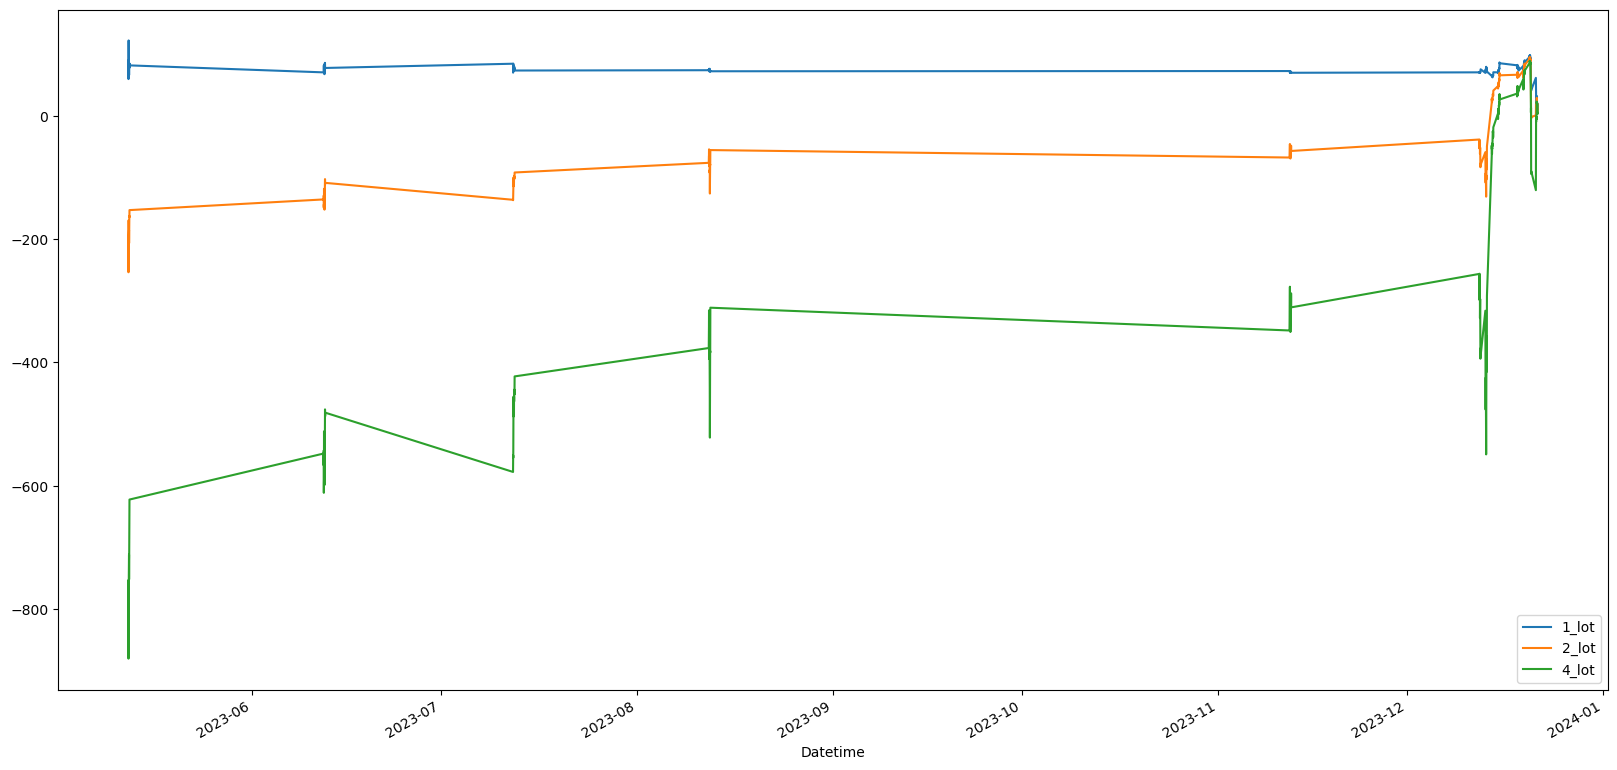

In [108]:
# Price of Iron Condor
nifty_condor_asymmetric_1_lot.premium_data['Price of Iron Condor'].plot(figsize=(20,10),label='1_lot')
nifty_condor_asymmetric_2_lot.premium_data['Price of Iron Condor'].plot(figsize=(20,10),label='2_lot')
nifty_condor_asymmetric_4_lot.premium_data['Price of Iron Condor'].plot(figsize=(20,10),label='4_lot')
plt.legend()


In [152]:
nifty_50_tickers=['ACC',
                 'ADANIPORTS', 
                 'ASIANPAINT', 
                 'AXISBANK', 'BAJAJ-AUTO', 
                 'BAJFINANCE', 'BAJAJFINSV', 
                 'BPCL', 'BHARTIARTL', 
                 'BRITANNIA', 'CIPLA', 'COALINDIA', 'DIVISLAB', 
                 'DRREDDY', 'EICHERMOT', 'GRASIM', 'HCLTECH', 'HDFCBANK', 
                 'HDFCLIFE', 'HEROMOTOCO', 'HINDALCO', 'HINDUNILVR', 'ICICIBANK', 
                 'INDUSINDBK', 'INFY', 'ITC', 'JSWSTEEL', 'KOTAKBANK', 'LT', 'M&M', 'MARICO', 
                 'MARUTI', 'NESTLEIND', 'NTPC', 'ONGC', 'POWERGRID', 'RELIANCE', 'SHREECEM', 'SBIN', 'SBILIFE', 
                 'TATACONSUM', 'TATAMOTORS', 'TATASTEEL', 'TCS', 'TECHM', 'TITAN', 'ULTRACEMCO', 'UPL', 'WIPRO']
#Check if stocks in above list are in the option_contrats_framework_2023
if set(nifty_50_tickers).issubset(ticker_list):
    print("All the provided Ticker are in the Framework 2023")
else:
    print("Following tickers are not in Framework 2023\n",set(nifty_50_tickers) - set(ticker_list))

All the provided Ticker are in the Framework 2023


In [ ]:
for ticker in nifty_50_tickers:
    condor=IronCondor(tickers=ticker,root_folder_path=root_folder,type='Symmetric')
    condor.calculate_iron_condor_performance()

{}